## EDA And Sensor Selection

### Work flow

1. Read in sensor and pull associated network
2. Graphical analysis of system
3. Get sensor data and analyse for completeness etc
4. Select sensors for study
5. Output OSM network of road network and associated sensors



In [1]:
# Import modules

import pandas as pd
import osmnx as ox
import numpy as np
import networkx as nx
import shapely
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import random
import mysql.connector
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.tsa.stattools import adfuller
from math import radians, sin, cos, sqrt, atan2
import csv
import heapq

#From ChatGPT
def traversal_time(length_meters, speed_mph):
    # Conversion factor: 1 mile per hour = 1609.34 meters per minute
    conversion_factor = 1609.34 / 60
    
    # Calculate time in minutes
    time_minutes = length_meters / (speed_mph * conversion_factor)
    
    return time_minutes

def haversine_distance(point1, point2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Extract latitude and longitude coordinates from the point objects
    lat1, lon1 = radians(point1.y), radians(point1.x)
    lat2, lon2 = radians(point2.y), radians(point2.x)

    # Calculate the differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula to calculate distance
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Calculate the distance
    distance = R * c

    return distance


# Function to perform the Augmented Dickey-Fuller test for stationarity
def test_stationarity(timeseries, var):
    # Calculate rolling statistics
    rolmean = timeseries[var].rolling(window=30).mean()
    rolstd = timeseries[var].rolling(window=30).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(timeseries[var], label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.show()

    # Perform Dickey-Fuller test
    result = adfuller(timeseries[var], autolag='AIC')
    print('Augmented Dickey-Fuller Test:')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')

def get_ts(sensor_id,start_date,end_date,cursor):
    
    # Get time series data for sensor
    sql_query = "select * from full_data where site_ID = '{}' and yr = '2022'".format(sensor_id)
    cursor.execute(sql_query)
    result = cursor.fetchall()
    ts = pd.DataFrame(result, columns=[desc[0] for desc in cursor.description])

    # Add date/time index

    i, d = divmod((ts['time_period'] / 4), 1)
    ts['Minute'] = [*map(dec_to_min_dict.get, list(d))]

    years = []
    months = []
    days = []

    for i,r in ts.iterrows():
        years.append(r['data_date'].year)
        months.append(r['data_date'].month)
        days.append(r['data_date'].day)

    ts['Year'] = years
    ts['Month'] = months
    ts['Day'] = days
    ts['Hour'] = ts['data_hour']

    ts['Datetime'] = pd.to_datetime(ts[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    ts.set_index('Datetime', inplace=True)
    ts = ts.sort_index()

    # Create a datetime index with 15-minute frequency
    datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
    ts_columns = ['Lane 1', 'Lane 2', 'Lane 3', 'All Lanes']

    # Create all vehicles data frame with 3 lanes
    ts_all = pd.DataFrame(index = datetime_index, columns = ts_columns)

    ts_all['Lane 1'] = ts[ts['Lane'] == 'lane1']['Total_Flow']
    ts_all['Lane 2'] = ts[ts['Lane'] == 'lane2']['Total_Flow']
    ts_all['Lane 3'] = ts[ts['Lane'] == 'lane3']['Total_Flow']
    ts_all['All Lanes'] = ts.groupby(ts.index).sum('Total_Flow')['Total_Flow']

    #Add Weekend Flag
    ts_all['Weekend'] = ts_all.index.dayofweek >= 5
    
    #Interpolate missing data
    for col in ts_columns:
        variable_name = f"{col}_interpolated"
        ts_all[variable_name] = ts_all[col].interpolate(method='time')
        ts_all[variable_name].bfill(inplace=True)
    
    return ts, ts_all
    
def analyse_time_series_of_sensor(sensor_id,start_date,end_date,cursor):
    
    # Get time series data for sensor
    sql_query = "select * from full_data where site_ID = '{}' and yr = '2022'".format(sensor_id)
    cursor.execute(sql_query)
    result = cursor.fetchall()
    ts = pd.DataFrame(result, columns=[desc[0] for desc in cursor.description])

    # Add date/time index

    i, d = divmod((ts['time_period'] / 4), 1)
    ts['Minute'] = [*map(dec_to_min_dict.get, list(d))]

    years = []
    months = []
    days = []

    for i,r in ts.iterrows():
        years.append(r['data_date'].year)
        months.append(r['data_date'].month)
        days.append(r['data_date'].day)

    ts['Year'] = years
    ts['Month'] = months
    ts['Day'] = days
    ts['Hour'] = ts['data_hour']

    ts['Datetime'] = pd.to_datetime(ts[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    ts.set_index('Datetime', inplace=True)
    ts = ts.sort_index()

    # Create a datetime index with 15-minute frequency
    datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
    ts_columns = ['Lane 1', 'Lane 2', 'Lane 3', 'All Lanes']

    # Create all vehicles data frame with 3 lanes
    ts_all = pd.DataFrame(index = datetime_index, columns = ts_columns)

    ts_all['Lane 1'] = ts[ts['Lane'] == 'lane1']['Total_Flow']
    ts_all['Lane 2'] = ts[ts['Lane'] == 'lane2']['Total_Flow']
    ts_all['Lane 3'] = ts[ts['Lane'] == 'lane3']['Total_Flow']
    ts_all['All Lanes'] = ts.groupby(ts.index).sum('Total_Flow')['Total_Flow']

    #Add Weekend Flag
    ts_all['Weekend'] = ts_all.index.dayofweek >= 5
    
    #Data Quality Checks
    # For each column - count zeros, nulls and outliers
    len_ts = len(ts_all)

    for col in ts_columns:
        print('-----------------')
        print('Next Columns : {}'.format(col))
        #Count zeros
        zero_count = (ts_all[col] == 0).sum()
        print('Count of zeros : {}'.format(zero_count))
        print('Rate of zeros : {:.1%}'.format(zero_count / len_ts))

        # Count nulls
        null_count = ts_all[col].isnull().sum()
        print('Count of nulls : {}'.format(null_count))
        print('Rate of nulls : {:.1%}'.format(null_count / len_ts))

        # Identify and count outliers (assuming values more than 2 standard deviations from the mean are outliers)
        mean_value = ts_all[col].mean()
        std_dev = ts_all[col].std()
        outlier_count = ((ts_all[col] > mean_value + 2 * std_dev) | (ts_all[col] < mean_value - 2 * std_dev)).sum()
        print('Count of outliers : {}'.format(outlier_count))
        print('Rate of outliers : {:.1%}'.format(outlier_count / len_ts))
        print('-----------------')
        print()
        print()
        
    plt.plot(ts_all['All Lanes'])
    plt.ylabel('Traffic Count')
    plt.show()
    
    #Interpolate missing data
    for col in ts_columns:
        variable_name = f"{col}_interpolated"
        ts_all[variable_name] = ts_all[col].interpolate(method='time')
        ts_all[variable_name].bfill(inplace=True)
        
        
    fig, ax = plt.subplots(2,1, figsize = [20,6])
    x_position = 0
    xlabels = []
    for i in range(1,53):
        week_data = ts_all[ts_all.index.isocalendar().week == i]
        ax[0].boxplot(week_data[week_data['Weekend'] == False]['All Lanes'].dropna(), positions=[x_position])
        x_position += 1
        xlabels.append(week_data.index[0].strftime('%m-%d'))

    ax[0].set_xticks(np.arange(len(xlabels)))
    ax[0].set_xticklabels(xlabels)
    ax[0].set_title('Weekly Boxplots (Weekday)')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Traffic Count')
    ax[0].xaxis.set_major_locator(MultipleLocator(2))

    x_position = 0
    xlabels = []
    for i in range(1,53):
        week_data = ts_all[ts_all.index.isocalendar().week == i]
        ax[1].boxplot(week_data[week_data['Weekend'] == True]['All Lanes'].dropna(), positions=[x_position])
        x_position += 1
        xlabels.append(week_data.index[0].strftime('%m-%d'))
    ax[1].set_title('Weekly Boxplots (Weekend)')
    ax[1].set_xticks(np.arange(len(xlabels)))
    ax[1].set_xticklabels(xlabels)
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Traffic Count')
    ax[1].xaxis.set_major_locator(MultipleLocator(2))

    plt.tight_layout()
    plt.show()
    
    #Typical Day Analysis

    fig, ax = plt.subplots(4,3, figsize = [20,8])

    ax_across = 0
    ax_down = 0

    for m in range(1,13):
        
        x_position = 0
        xlabels = []
        for h in range(24):
            
            month_hour_data = ts_all[(ts_all.index.month == m) & (ts_all.index.hour == h)]
            ax[ax_down,ax_across].boxplot(month_hour_data[month_hour_data['Weekend'] == True]['All Lanes'].dropna(), positions=[x_position])
            x_position += 1
            xlabels.append(month_hour_data.index[0].strftime('%H:%M'))
        ax[ax_down,ax_across].set_xticks(np.arange(len(xlabels)))
        ax[ax_down,ax_across].set_xticklabels(xlabels)
        ax[ax_down,ax_across].xaxis.set_major_locator(MultipleLocator(4))
        
        ax[ax_down,ax_across].set_title(month_hour_data.index[0].strftime('%B'))
        
        if ax_across < 2:
            ax_across += 1
        else:
            ax_across = 0
            ax_down += 1

    plt.suptitle('Typical Weekend Day by Month')
    plt.tight_layout()
    plt.show()


    fig, ax = plt.subplots(4,3, figsize = [20,8])

    ax_across = 0
    ax_down = 0

    for m in range(1,13):
        
        x_position = 0
        xlabels = []
        for h in range(24):
            month_hour_data = ts_all[(ts_all.index.month == m) & (ts_all.index.hour == h)]
            ax[ax_down,ax_across].boxplot(month_hour_data[month_hour_data['Weekend'] == False]['All Lanes'].dropna(), positions=[x_position])
            x_position += 1
            xlabels.append(month_hour_data.index[0].strftime('%H:%M'))
        ax[ax_down,ax_across].set_xticks(np.arange(len(xlabels)))
        ax[ax_down,ax_across].set_xticklabels(xlabels)
        ax[ax_down,ax_across].xaxis.set_major_locator(MultipleLocator(4))
        
        ax[ax_down,ax_across].set_title(month_hour_data.index[0].strftime('%B'))
        
        if ax_across < 2:
            ax_across += 1
        else:
            ax_across = 0
            ax_down += 1

    plt.suptitle('Typical Weekday Day by Month')
    plt.tight_layout()
    plt.show()
    
    
    # Perform seasonal decomposition
    result = seasonal_decompose(ts_all['All Lanes_interpolated'], model='additive', period=365)

    # Plot the original, trend, seasonal, and residual components
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(ts_all['All Lanes'], label='Original')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residual')
    plt.legend()

    plt.suptitle('Seasonal Decomposition Analysis')
    plt.tight_layout()
    plt.show()
    
    # Call the stationarity analysis function
    test_stationarity(ts_all, 'All Lanes_interpolated')
    
    #Heatmap of flow over time
    
    #Construct heapmap

    num_days = 365
    heatmap = np.zeros((24,num_days))

    m = 1
    d = 1
    array_ind = 0
    for i in range(num_days):
        month_day_data = ts_all[(ts_all.index.month == m) & (ts_all.index.day == d)]
        if len(month_day_data) > 0:
            hourly_aggregated = month_day_data.resample('H').sum()
            heatmap[:,array_ind] = hourly_aggregated['All Lanes_interpolated'].values

            array_ind += 1
            d += 1
        else:
            m += 1
            d = 1
            month_day_data = ts_all[(ts_all.index.month == m) & (ts_all.index.day == d)]
            hourly_aggregated = month_day_data.resample('H').sum()
            heatmap[:,array_ind] = hourly_aggregated['All Lanes_interpolated'].values
            array_ind += 1
    xlabels = pd.date_range(start=start_date, periods=num_days, freq='D')
    ylabels = hourly_aggregated.sort_index( ascending=False).index.strftime('%H:%M')

    # Specify the size of the plot using figsize
    fig, ax = plt.subplots(figsize=(30, 8))

    # Plot the heatmap
    im = ax.imshow(np.flip(heatmap, axis = 0), cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax)  # Add a colorbar on the side
    ax.set_title('Hourly Flow Heat Map')
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels.strftime('%B'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1,bymonthday=15))

    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_yticklabels(ylabels)
    ax.yaxis.set_major_locator(MultipleLocator(4))

    plt.show()
    
    #Plot Data Quality Over Time
    
    mean_value_l1 = ts_all['Lane 1'].mean()
    std_dev_l1 = ts_all['Lane 1'].std()

    mean_value_l2 = ts_all['Lane 2'].mean()
    std_dev_l2 = ts_all['Lane 2'].std()

    mean_value_l3 = ts_all['Lane 3'].mean()
    std_dev_l3 = ts_all['Lane 3'].std()

    mean_value_lall = ts_all['All Lanes'].mean()
    std_dev_lall = ts_all['All Lanes'].std()

    num_days = 365
    zero_counts = np.zeros((4,num_days))
    null_counts = np.zeros((4,num_days))
    outlier_counts = np.zeros((4,num_days))

    m = 1
    d = 1
    array_ind = 0

    for i in range(num_days):

        day_data = ts_all[(ts_all.index.month == m) & (ts_all.index.day == d)]
        if len(day_data) > 0:
            zero_counts[0,array_ind] = ((day_data['Lane 1'] == 0).sum() / len(day_data)) * 100
            zero_counts[1,array_ind] = ((day_data['Lane 2'] == 0).sum() / len(day_data)) * 100
            zero_counts[2,array_ind] = ((day_data['Lane 3'] == 0).sum() / len(day_data)) * 100
            zero_counts[3,array_ind] = ((day_data['All Lanes'] == 0).sum() / len(day_data)) * 100

            null_counts[0,array_ind] = (day_data['Lane 1'].isnull().sum() / len(day_data)) * 100
            null_counts[1,array_ind] = (day_data['Lane 2'].isnull().sum() / len(day_data)) * 100
            null_counts[2,array_ind] = (day_data['Lane 3'].isnull().sum() / len(day_data)) * 100
            null_counts[3,array_ind] = (day_data['All Lanes'].isnull().sum() / len(day_data)) * 100

            outlier_counts[0,array_ind] = (((day_data['Lane 1'] > mean_value_l1 + 2 * std_dev_l1) | (day_data['Lane 1'] < mean_value_l1 - 2 * std_dev_l1)).sum()) / len(day_data) * 100
            outlier_counts[1,array_ind] = (((day_data['Lane 2'] > mean_value_l2 + 2 * std_dev_l2) | (day_data['Lane 1'] < mean_value_l2 - 2 * std_dev_l2)).sum()) / len(day_data) * 100
            outlier_counts[2,array_ind] = (((day_data['Lane 3'] > mean_value_l3 + 2 * std_dev_l3) | (day_data['Lane 1'] < mean_value_l3 - 2 * std_dev_l3)).sum()) / len(day_data) * 100
            outlier_counts[3,array_ind] = (((day_data['All Lanes'] > mean_value_lall + 2 * std_dev_lall) | (day_data['All Lanes'] < mean_value_lall - 2 * std_dev_lall)).sum()) / len(day_data) * 100
            array_ind += 1
            d += 1
            
        else:
            m += 1
            d = 1
            day_data = ts_all[(ts_all.index.month == m) & (ts_all.index.day == d)]
            zero_counts[0,array_ind] = ((day_data['Lane 1'] == 0).sum() / len(day_data)) * 100
            zero_counts[1,array_ind] = ((day_data['Lane 2'] == 0).sum() / len(day_data)) * 100
            zero_counts[2,array_ind] = ((day_data['Lane 3'] == 0).sum() / len(day_data)) * 100
            zero_counts[3,array_ind] = ((day_data['All Lanes'] == 0).sum() / len(day_data)) * 100

            null_counts[0,array_ind] = (day_data['Lane 1'].isnull().sum() / len(day_data)) * 100
            null_counts[1,array_ind] = (day_data['Lane 2'].isnull().sum() / len(day_data)) * 100
            null_counts[2,array_ind] = (day_data['Lane 3'].isnull().sum() / len(day_data)) * 100
            null_counts[3,array_ind] = (day_data['All Lanes'].isnull().sum() / len(day_data)) * 100

            outlier_counts[0,array_ind] = (((day_data['Lane 1'] > mean_value_l1 + 2 * std_dev_l1) | (day_data['Lane 1'] < mean_value_l1 - 2 * std_dev_l1)).sum()) / len(day_data) * 100
            outlier_counts[1,array_ind] = (((day_data['Lane 2'] > mean_value_l2 + 2 * std_dev_l2) | (day_data['Lane 1'] < mean_value_l2 - 2 * std_dev_l2)).sum()) / len(day_data) * 100
            outlier_counts[2,array_ind] = (((day_data['Lane 3'] > mean_value_l3 + 2 * std_dev_l3) | (day_data['Lane 1'] < mean_value_l3 - 2 * std_dev_l3)).sum()) / len(day_data) * 100
            outlier_counts[3,array_ind] = (((day_data['All Lanes'] > mean_value_lall + 2 * std_dev_lall) | (day_data['All Lanes'] < mean_value_lall - 2 * std_dev_lall)).sum()) / len(day_data) * 100
            array_ind += 1
            
    xlabels = pd.date_range(start=start_date, periods=num_days, freq='D')    
    fig, ax = plt.subplots(3,1, figsize = [20,6])

    ax[0].plot(zero_counts[0],label = 'Lane 1')
    ax[0].plot(zero_counts[1],label = 'Lane 2')
    ax[0].plot(zero_counts[2],label = 'Lane 3')
    ax[0].plot(zero_counts[3],label = 'All Lanes')
    ax[0].set_xticks(np.arange(len(xlabels)))
    ax[0].set_xticklabels(xlabels.strftime('%b-%d'))
    ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax[0].set_title('Zero Rate')
    ax[0].set_ylabel('Percent')
    ax[0].legend()

    ax[1].plot(null_counts[0],label = 'Lane 1')
    ax[1].plot(null_counts[1],label = 'Lane 2')
    ax[1].plot(null_counts[2],label = 'Lane 3')
    ax[1].plot(null_counts[3],label = 'All Lanes')
    ax[1].set_xticks(np.arange(len(xlabels)))
    ax[1].set_xticklabels(xlabels.strftime('%b-%d'))
    ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax[1].set_title('Missing Rate')
    ax[1].set_ylabel('Percent')
    ax[1].legend()

    ax[2].plot(outlier_counts[0],label = 'Lane 1')
    ax[2].plot(outlier_counts[1],label = 'Lane 2')
    ax[2].plot(outlier_counts[2],label = 'Lane 3')
    ax[2].plot(outlier_counts[3],label = 'All Lanes')
    ax[2].set_xticks(np.arange(len(xlabels)))
    ax[2].set_xticklabels(xlabels.strftime('%b-%d'))
    ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax[2].set_title('Outlier Rate')
    ax[2].set_ylabel('Percent')
    ax[2].legend()

    plt.tight_layout()
    plt.show()
    
    return ts, ts_all

/tmp/ipykernel_321868/1484312045.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Get sensors
sensors = pd.read_csv('Data/midas_sensor_locations.csv')

#Get network for area just for pimary roads etc
cf = '["highway"~"motorway|motorway_link|primary|trunk"]'
G = ox.graph_from_place('Kent, United Kingdom', network_type='drive', custom_filter=cf, simplify=True)

edge_attributes = ox.graph_to_gdfs(G, nodes=True)[1]

#Tidy Network
#Where there is multiple road types select 1 (at random)
road_types = []
for i in list(edge_attributes['highway']):
    if isinstance(i, str): 
        road_types.append(i)
    else:
        road_types.append(i[0])
        
edge_attributes['highway'] = road_types

#Get Dict of road type to speed

#For edges with missing speed impute using mode
road_type_speed_limit = {}
for type in list(edge_attributes['highway'].value_counts().index):
    road_type_speed_limit[type] = edge_attributes[edge_attributes['highway'] == type]['maxspeed'].mode().values[0]


#Where speed missing or multuple, take from dict
speed = []
for i,r in edge_attributes.iterrows():
    #String case
    if isinstance(r['maxspeed'], str):
        speed.append(int("".join(filter(str.isdigit, r['maxspeed']))))
    #List case
    else:
        speed.append(int("".join(filter(str.isdigit, road_type_speed_limit[r['highway']]))))
        
edge_attributes['speed'] = speed

#Add travesal time to graph
for i,r in edge_attributes.iterrows():
    G[i[0]][i[1]][i[2]]['traversal_cost'] = traversal_time(r['length'],r['speed'])
    
node_attributes, edge_attributes = ox.graph_to_gdfs(G, nodes=True)
#Get edge centroids
edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y
#Add edge index
edge_attributes['edge_index'] = range(len(edge_attributes))
#Get boundary
graph_boundary=shapely.geometry.box(edge_attributes.geometry.total_bounds[0],edge_attributes.geometry.total_bounds[1],edge_attributes.geometry.total_bounds[2],edge_attributes.geometry.total_bounds[3])

#Read in sensors
sensor_points = []
for i,r in sensors.iterrows():
    sensor_points.append(Point([r['Longitude'],r['Latitude']]))
sensors['geometry'] = sensor_points

sensors_in_study = sensors[[graph_boundary.contains(point) for point in sensor_points]]

sensors_gdf = GeoDataFrame(sensors_in_study, crs="EPSG:4326", geometry=sensors_in_study['geometry'])
sensors_gdf.to_file("Data/examples/sensor_locations.json", driver="GeoJSON")
sensor_nearest_edges = ox.distance.nearest_edges(G, list(sensors_in_study['Longitude']), list(sensors_in_study['Latitude']), interpolate=None, return_dist=False)

/tmp/ipykernel_321868/2174658753.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/tmp/ipykernel_321868/2174658753.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


In [3]:
#Randomly sample sensors to output sensor and nearest edge to check

rand_sens = random.randrange(0,len(sensors_in_study)-1)

sensor_to_check = sensors_gdf.iloc[rand_sens].to_frame().T
edge_to_check = edge_attributes.loc[sensor_nearest_edges[rand_sens]].to_frame().T#

sensor_check_gdf = GeoDataFrame(sensor_to_check, crs="EPSG:4326", geometry=sensor_to_check['geometry'])
sensor_check_gdf['geometry'].to_file("Data/examples/sensor_check.json", driver="GeoJSON")

edge_check_gdf = GeoDataFrame(edge_to_check, crs="EPSG:4326", geometry=edge_to_check['geometry'])
edge_check_gdf['geometry'].to_file("Data/examples/edge_check.json", driver="GeoJSON")

## Time Series Exploratory Data Analysis

- Completeness
- Methods for missing data imputation
- Analyse stationarity of data
- Analyse any seasonanality


### Specific To Do:

- For a random sensor:
    - Data quality checks - how are nulls represented? Any processing steps to handle this? How to measure null / missing / outliers
    - What about lanes / vehicle types?
        - Treat separately? Aggregate? Ignore (for now)? Anything else?
    - More detailed time series checks e.g., stationarity etc with analysis & interpretation

In [4]:
dec_to_min_dict = {
    0.0 : 0,
    0.25 : 15,
    0.50 : 30,
    0.75 : 45
    }

In [5]:
host = "localhost"
user = "chris"
password = "password"
database = "midas"

# Establish a database connection
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor(buffered=True)

In [6]:
roads = []
direction = []
for i in list(sensors_in_study['site_ID']):
    roads.append(i.split('/')[0])
    direction.append(i[-1:])
sensors_in_study['Road'] = roads
sensors_in_study['Direction'] = direction

/tmp/ipykernel_321868/1105348738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensors_in_study['Road'] = roads
/tmp/ipykernel_321868/1105348738.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensors_in_study['Direction'] = direction


In [7]:
rand_sens = random.randrange(0,len(sensors_in_study)-1)
next_sensor = sensors_gdf.iloc[rand_sens].to_frame().T

/tmp/ipykernel_321868/1484312045.py:162: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


-----------------
Next Columns : Lane 1
Count of zeros : 496
Rate of zeros : 1.4%
Count of nulls : 13602
Rate of nulls : 38.8%
Count of outliers : 91
Rate of outliers : 0.3%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 480
Rate of zeros : 1.4%
Count of nulls : 13736
Rate of nulls : 39.2%
Count of outliers : 154
Rate of outliers : 0.4%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 1143
Rate of zeros : 3.3%
Count of nulls : 13917
Rate of nulls : 39.7%
Count of outliers : 1353
Rate of outliers : 3.9%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 859
Rate of zeros : 2.5%
Count of nulls : 2305
Rate of nulls : 6.6%
Count of outliers : 1392
Rate of outliers : 4.0%
-----------------




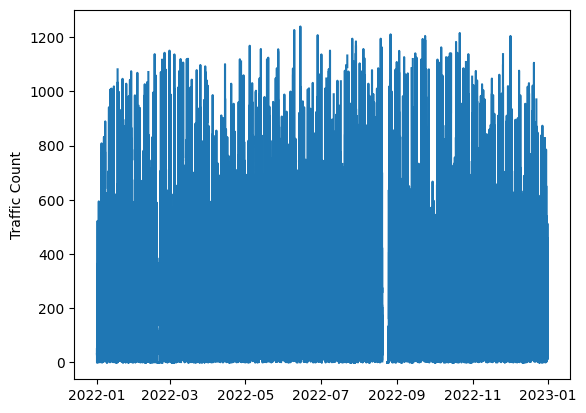

/tmp/ipykernel_321868/1484312045.py:211: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/tmp/ipykernel_321868/1484312045.py:211: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

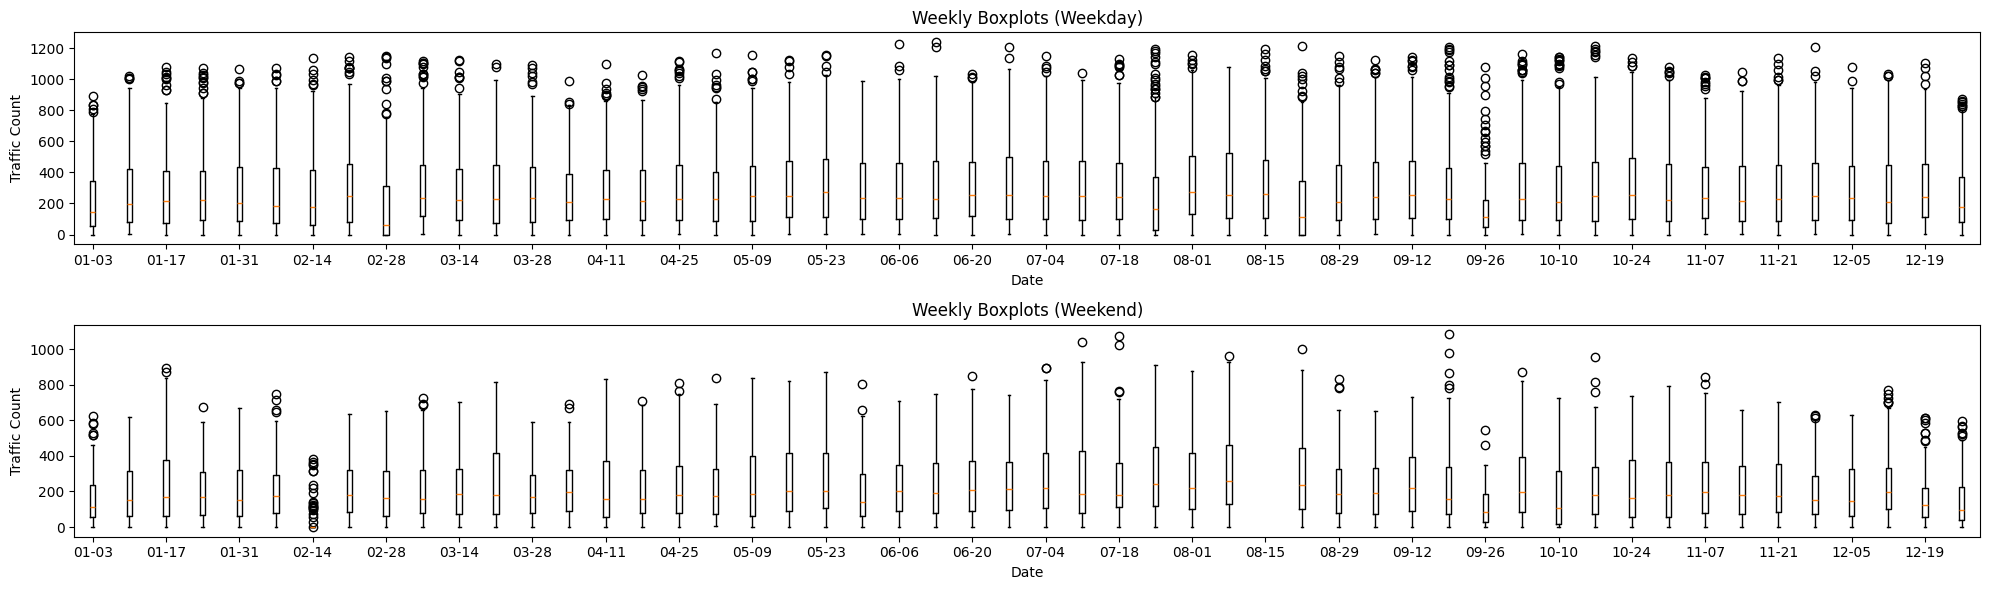

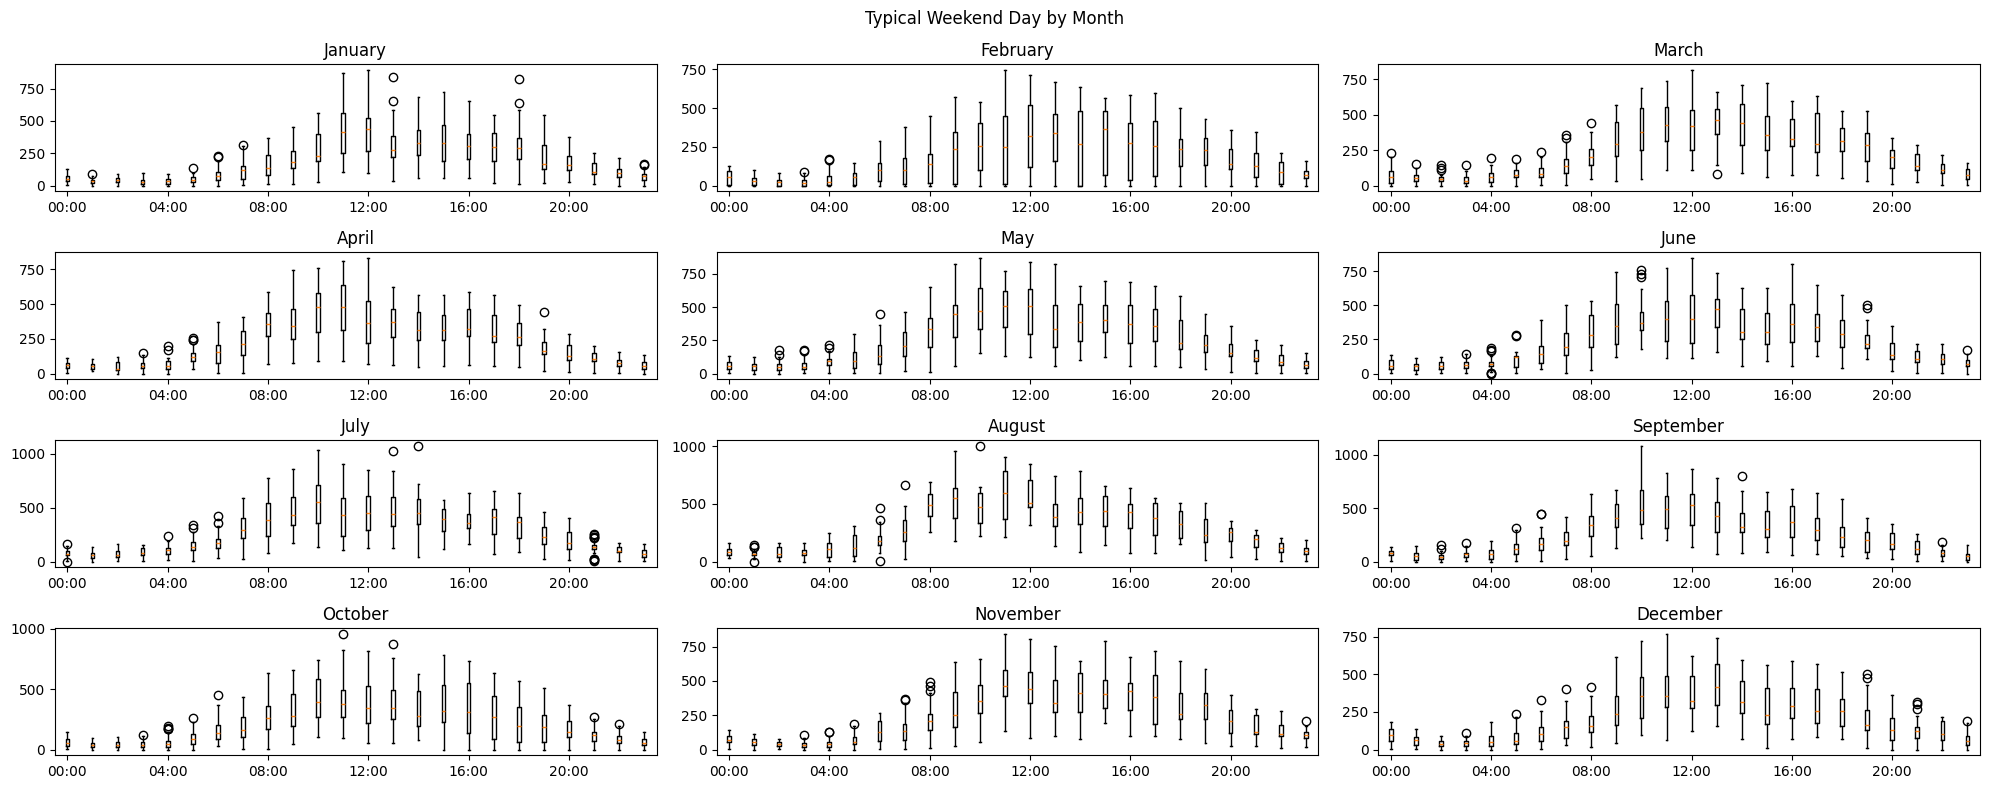

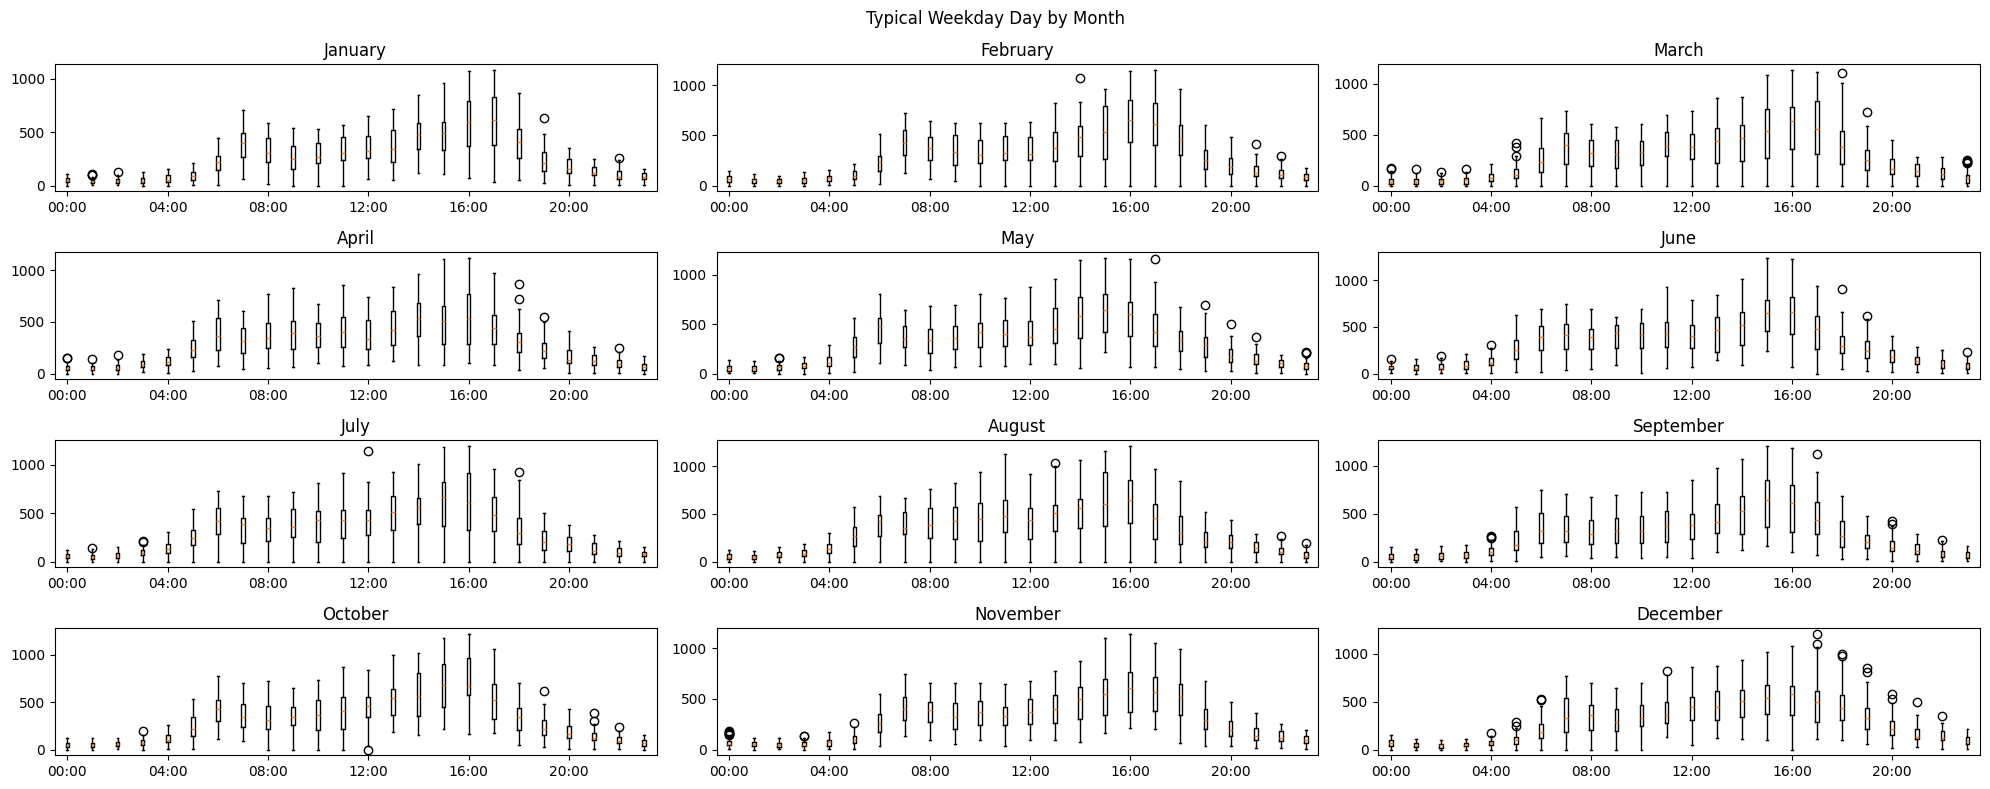

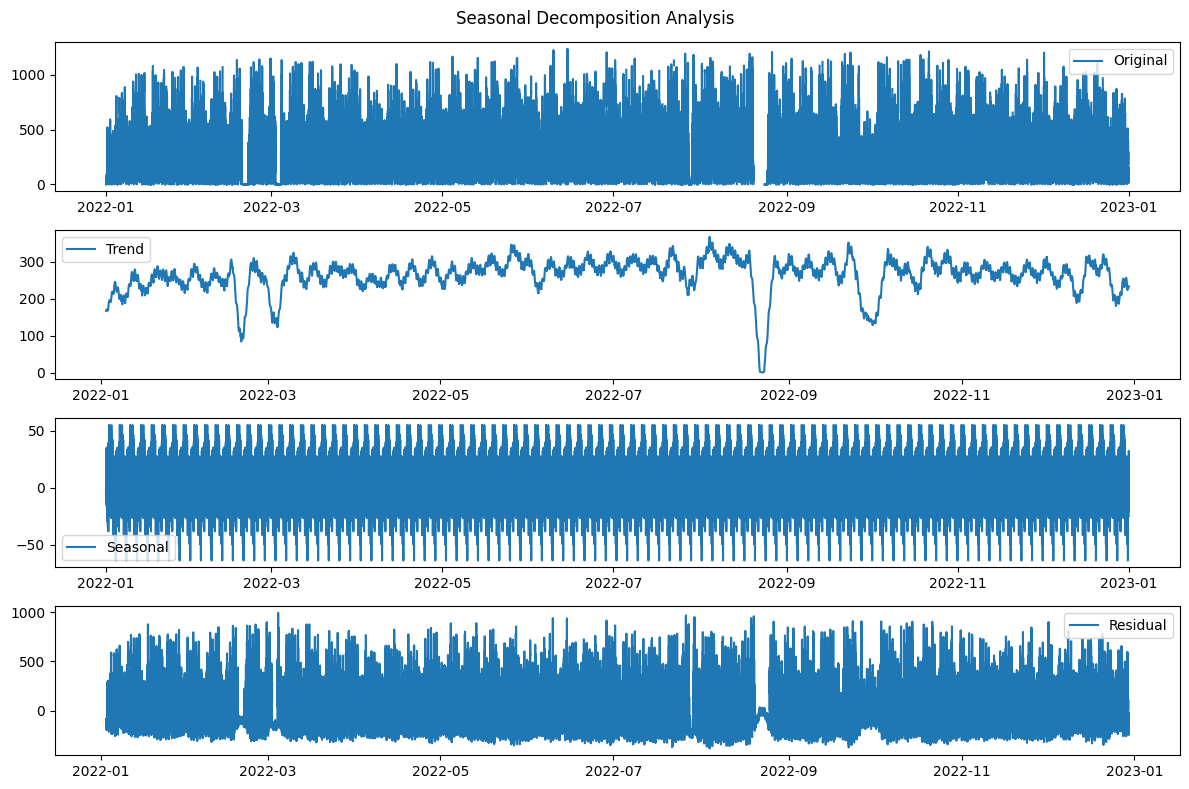

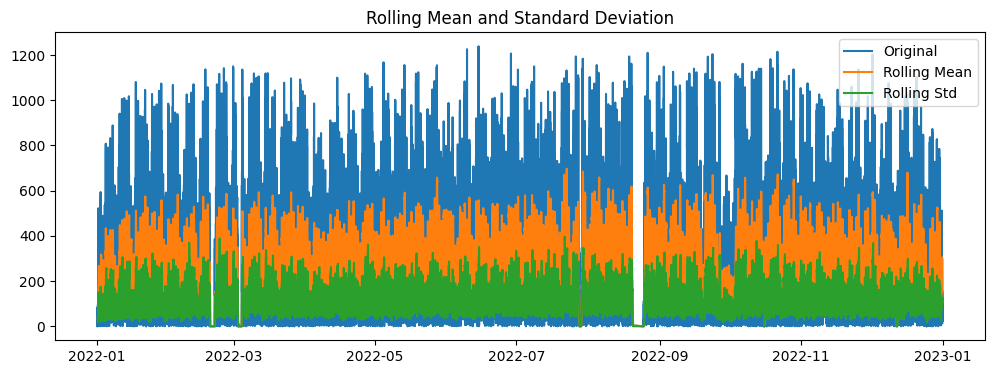

Augmented Dickey-Fuller Test:
Test Statistic: -34.28961233606478
p-value: 0.0
Critical Values: {'1%': -3.430536920280192, '5%': -2.861622614143799, '10%': -2.5668139729124237}


/tmp/ipykernel_321868/1484312045.py:353: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()
/tmp/ipykernel_321868/1484312045.py:362: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()


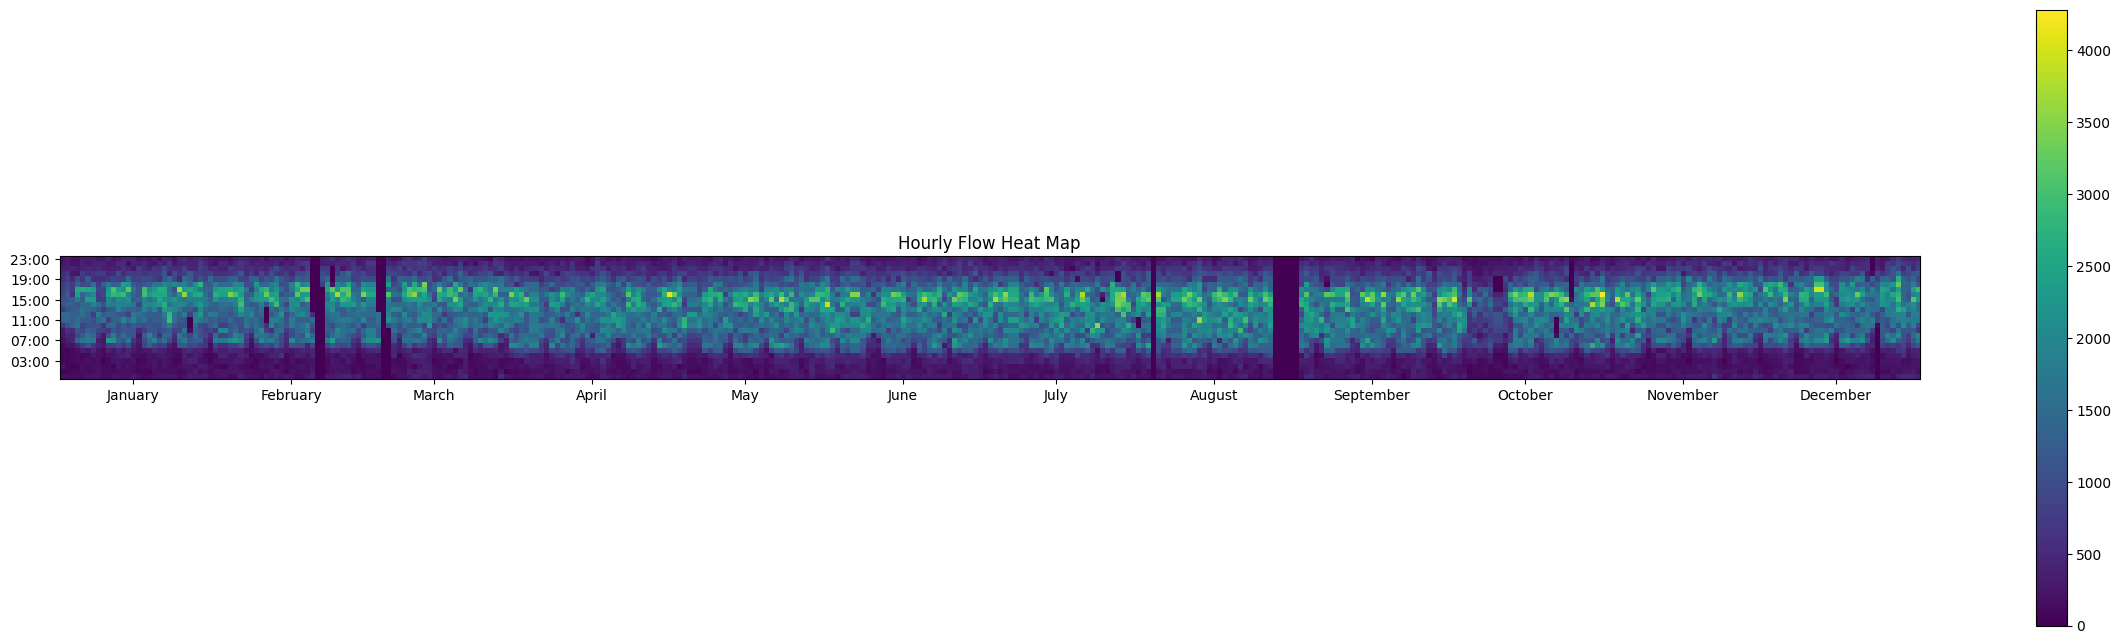

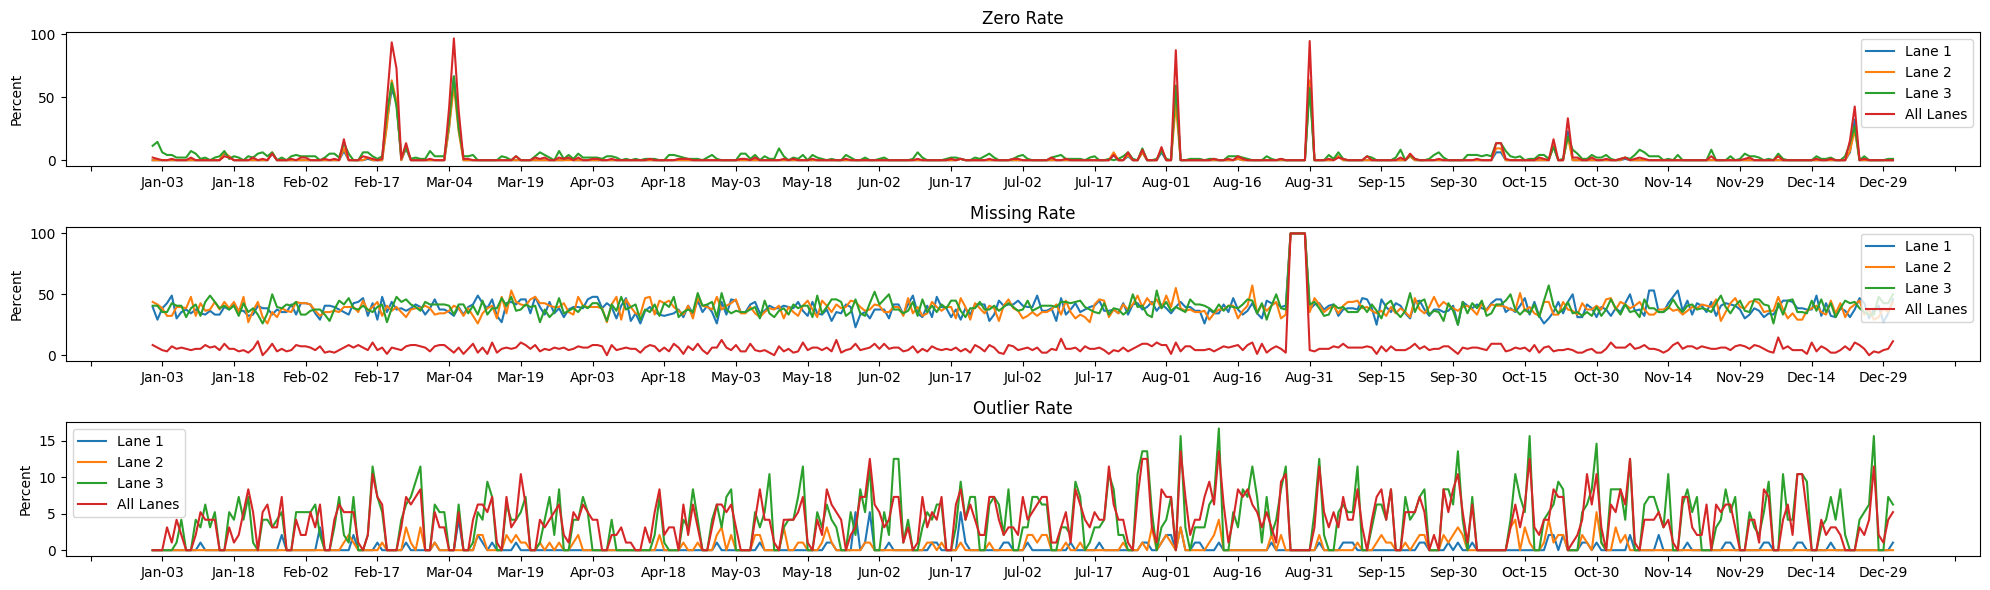

In [8]:
start_date = '2022-01-01'
end_date = '2022-12-31 23:45:00'  # End of December 2022

rand_sens = random.randrange(0,len(sensors_in_study)-1)
next_sensor = sensors_gdf.iloc[rand_sens].to_frame().T
sensor_id = next_sensor['site_ID'].values[0]
ts_1, ts_all_1 = analyse_time_series_of_sensor(sensor_id,start_date,end_date,cursor)

-----------------
Next Columns : Lane 1
Count of zeros : 14230
Rate of zeros : 40.6%
Count of nulls : 14852
Rate of nulls : 42.4%
Count of outliers : 1638
Rate of outliers : 4.7%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 14115
Rate of zeros : 40.3%
Count of nulls : 14949
Rate of nulls : 42.7%
Count of outliers : 1815
Rate of outliers : 5.2%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 14135
Rate of zeros : 40.3%
Count of nulls : 15050
Rate of nulls : 43.0%
Count of outliers : 1633
Rate of outliers : 4.7%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 22528
Rate of zeros : 64.3%
Count of nulls : 3014
Rate of nulls : 8.6%
Count of outliers : 2296
Rate of outliers : 6.6%
-----------------




/tmp/ipykernel_321868/1484312045.py:162: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


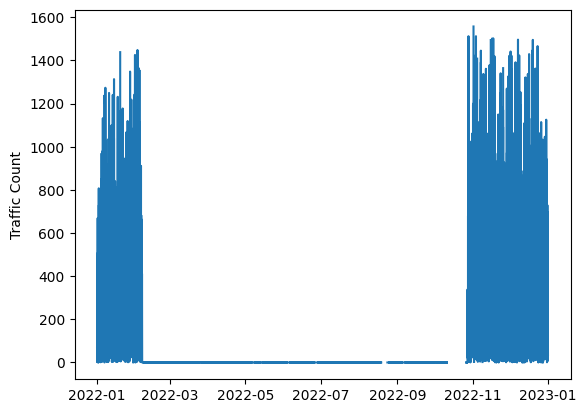

/tmp/ipykernel_321868/1484312045.py:211: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/tmp/ipykernel_321868/1484312045.py:211: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

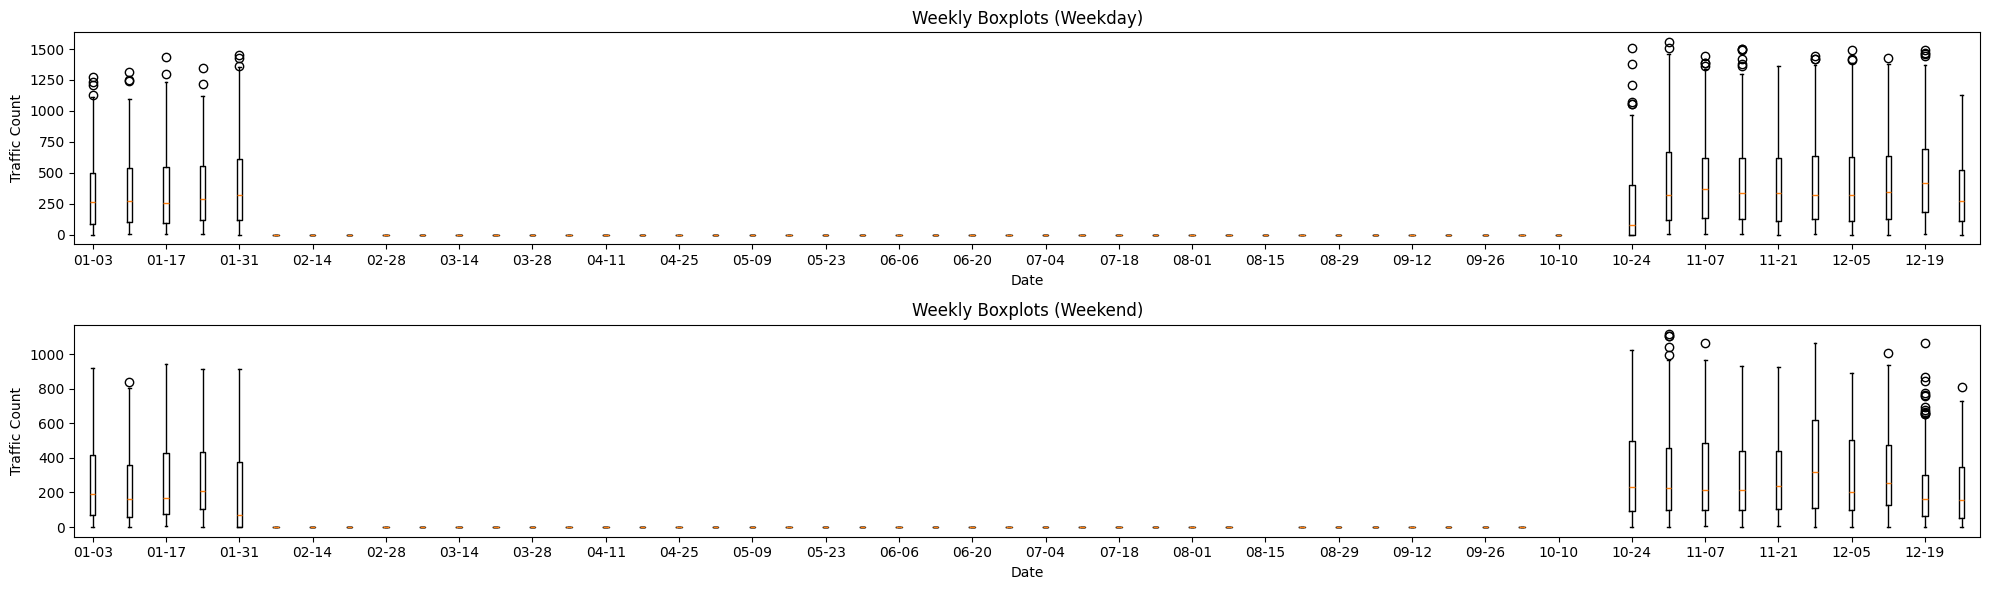

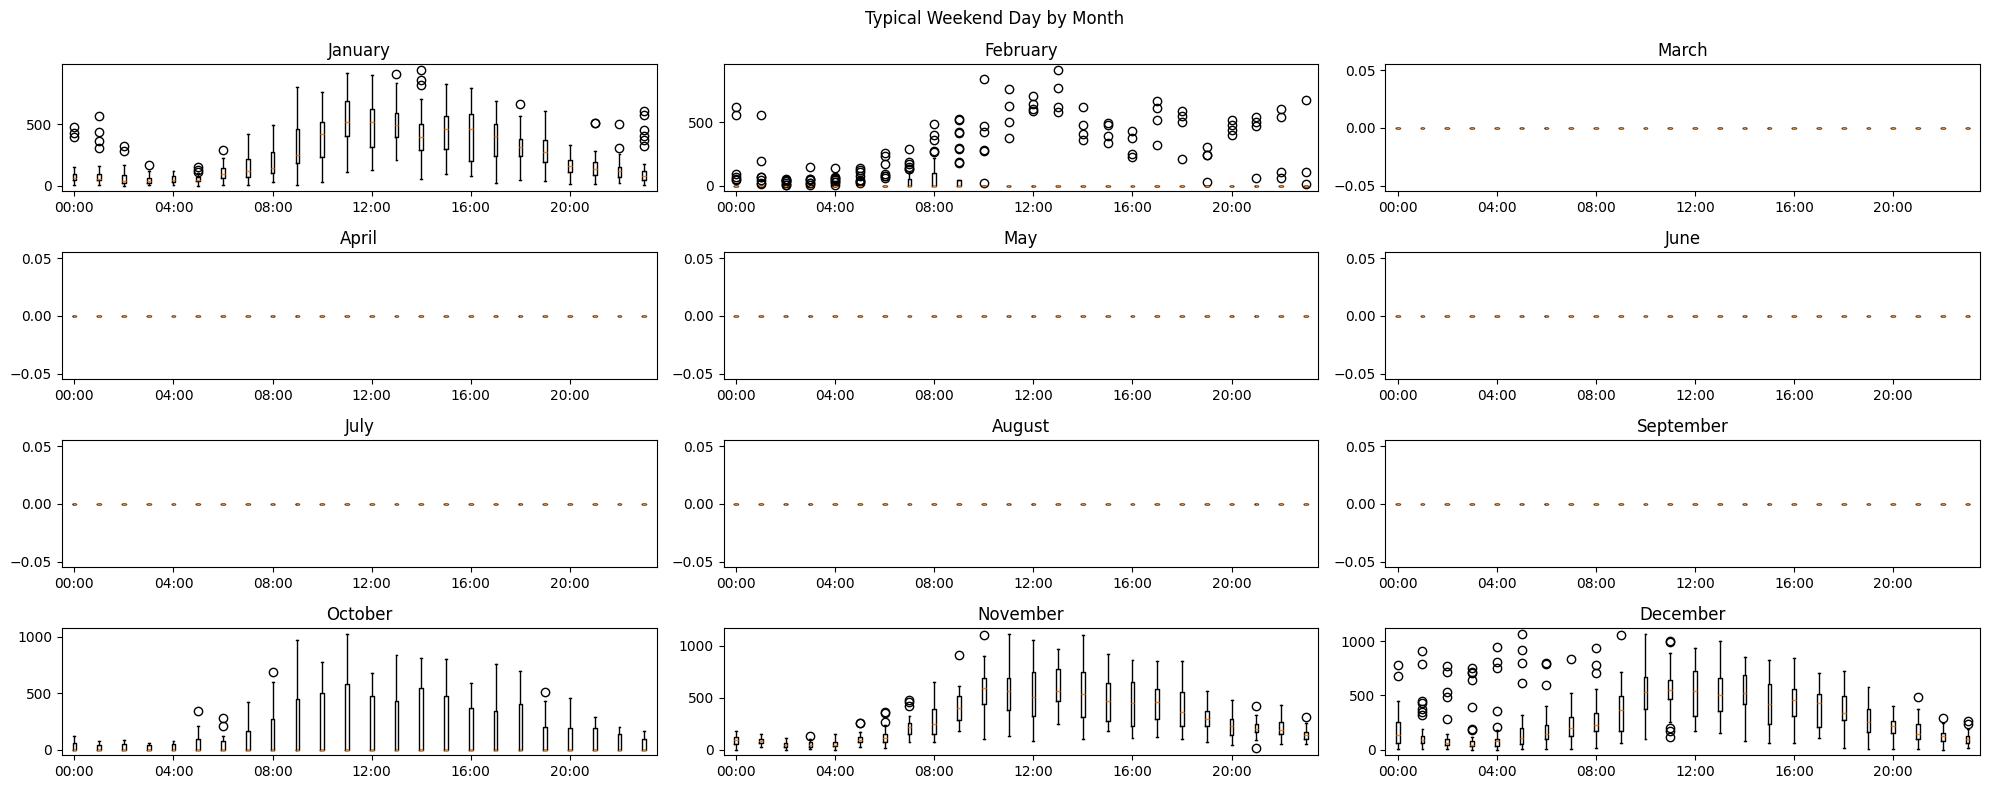

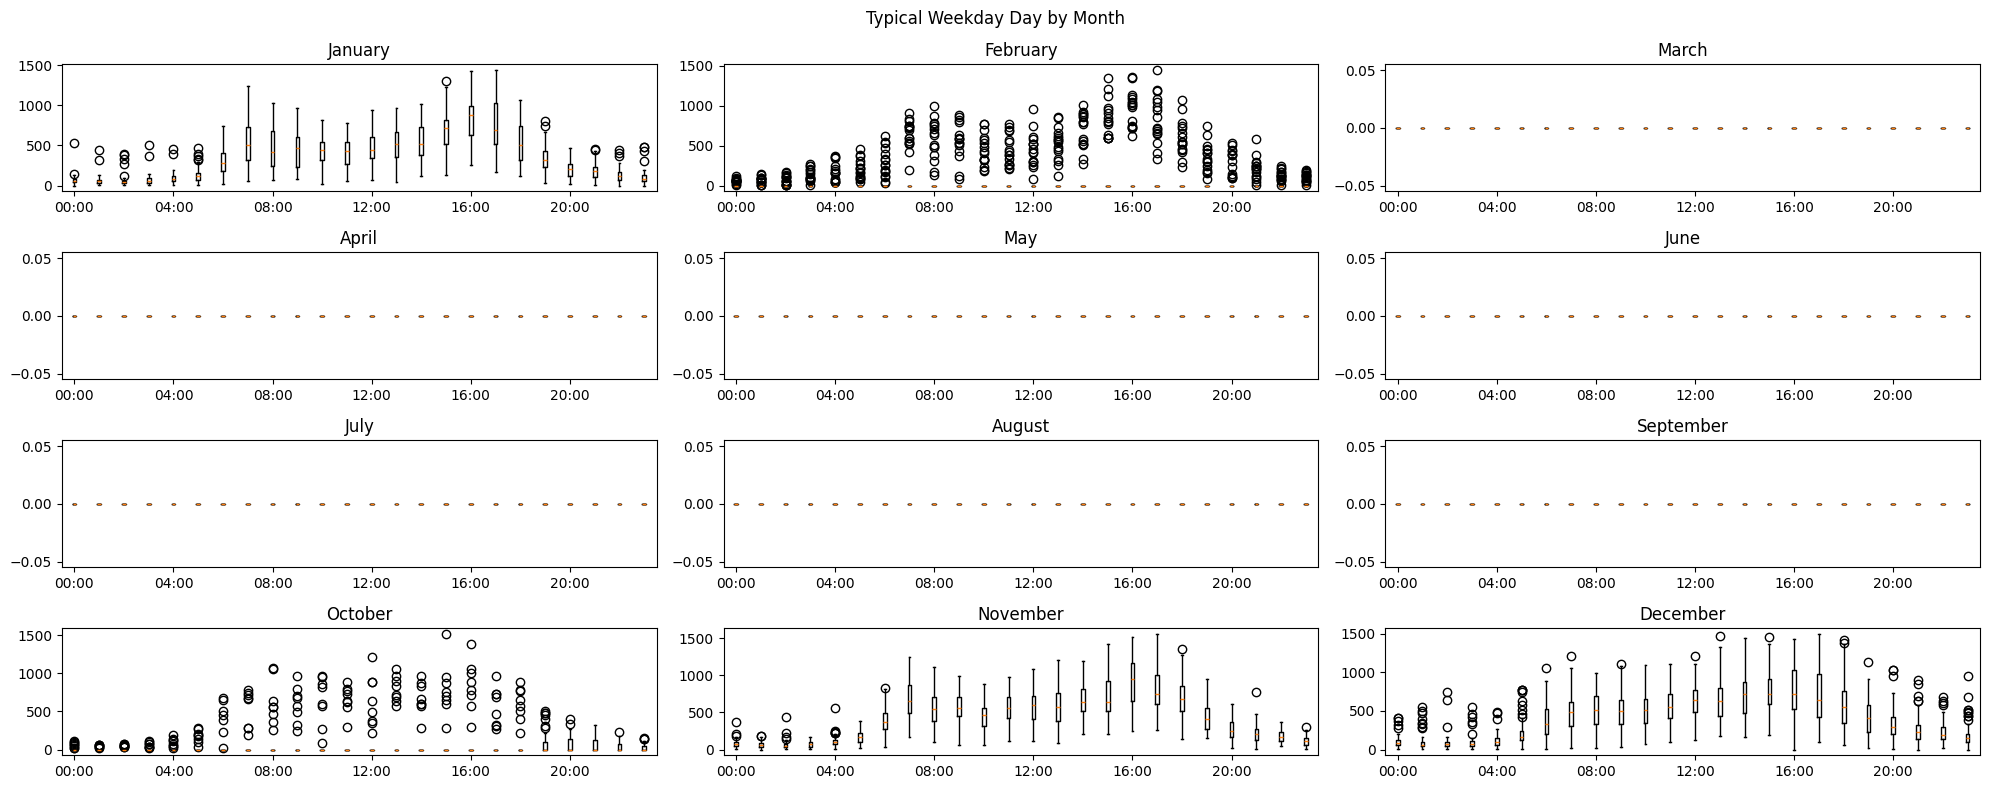

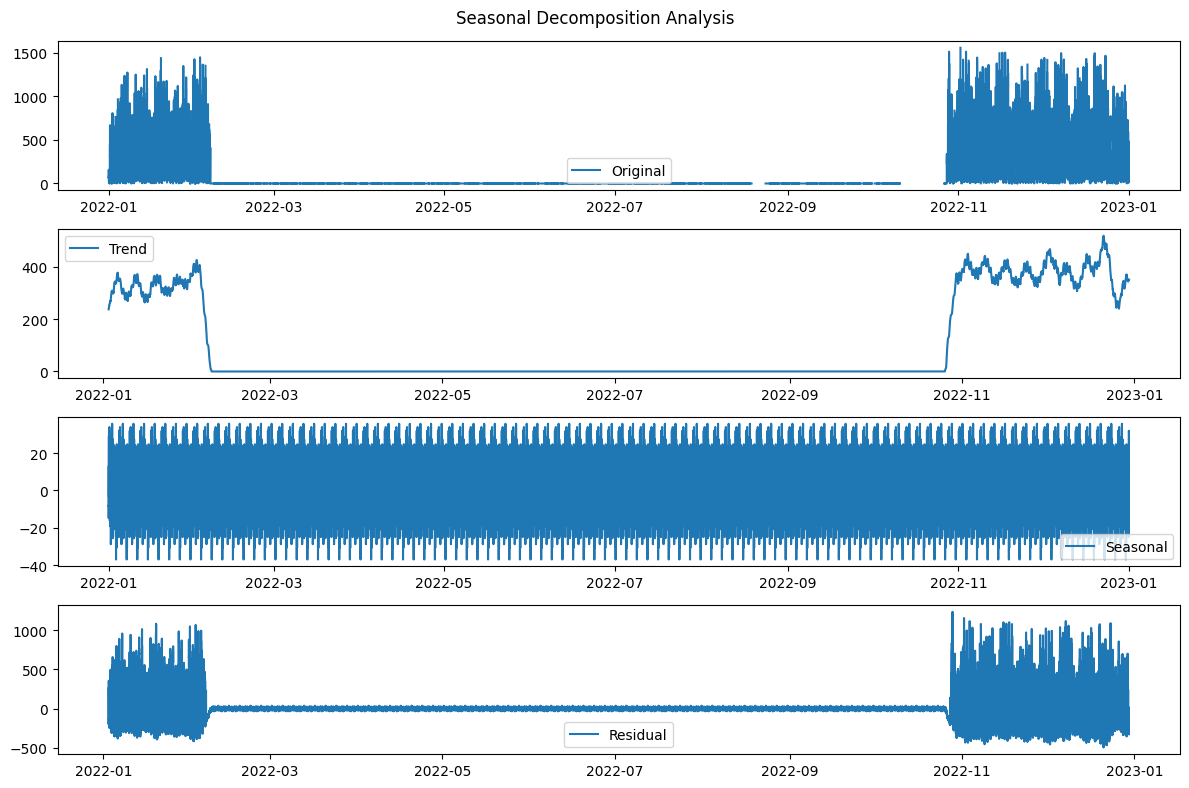

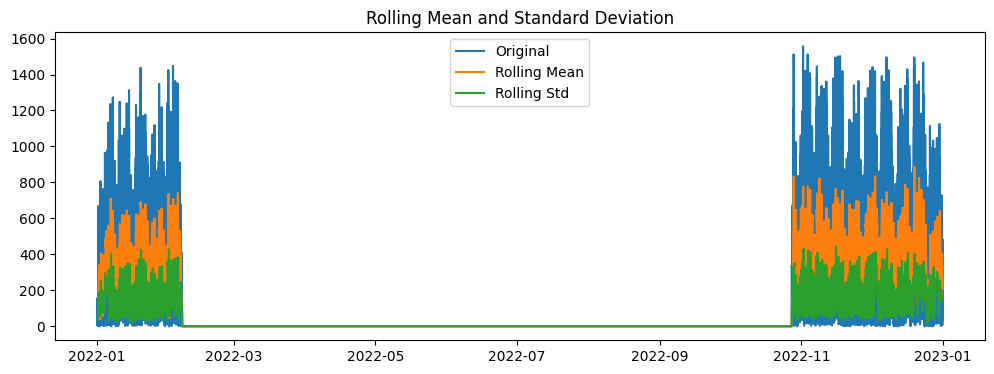

Augmented Dickey-Fuller Test:
Test Statistic: -11.532071293571189
p-value: 3.810523847117937e-21
Critical Values: {'1%': -3.430536920280192, '5%': -2.861622614143799, '10%': -2.5668139729124237}


/tmp/ipykernel_321868/1484312045.py:353: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()
/tmp/ipykernel_321868/1484312045.py:362: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()


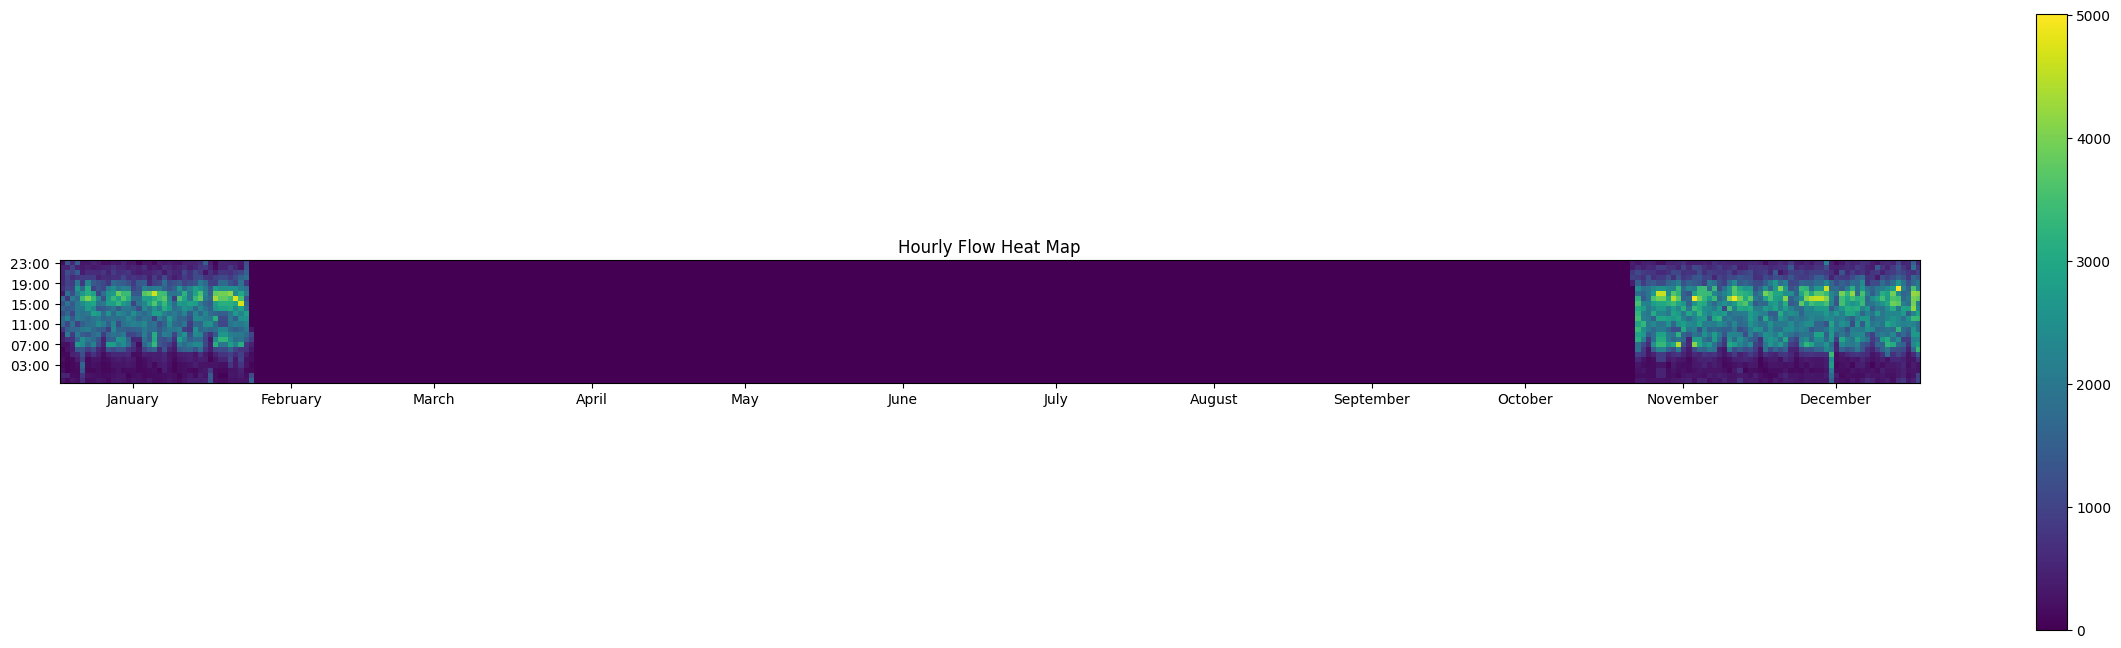

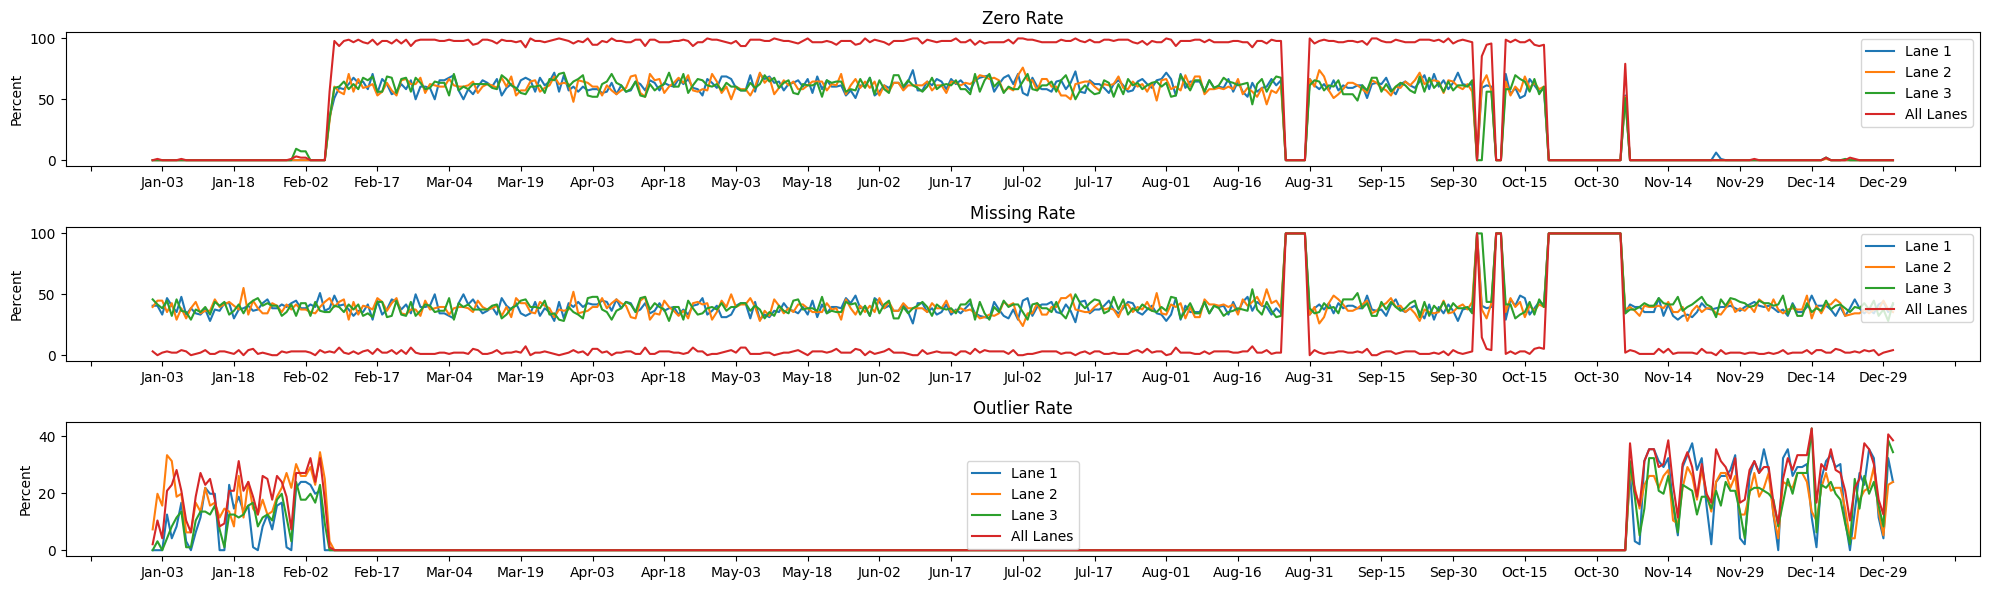

In [9]:
rand_sens = random.randrange(0,len(sensors_in_study)-1)
next_sensor = sensors_gdf.iloc[rand_sens].to_frame().T
sensor_id = next_sensor['site_ID'].values[0]
ts_2, ts_all_2 = analyse_time_series_of_sensor(sensor_id,start_date,end_date,cursor)

### Time Series Analysis

- Missing data
- Summary stats over time. Show summarised boxplots over time.
- Seasonal decomposition
- Auto correlation / partial auto correlation analysis
- Stationarity analysis
- Time-series decomposition
- Heapmaps of data

## GeoSpatial Analysis

### To Consider (ChatGPT):

- Spatial Correlation Analysis (Calculate spatial correlation coefficients, such as Pearson correlation or spatial autocorrelation, between pairs of sensors)
- Geospatial Visualization (Create geospatial visualizations, such as heatmaps or spatial scatter plots, to visually explore patterns and relationships between sensor locations)
- Distance-Based Analysis (Explore the relationship between sensor readings and the physical distance between sensors. Techniques such as variograms or semivariograms can be used to analyze how the spatial correlation changes with distance.)
- Spatial Regression Models (Use spatial regression models to account for spatial dependencies explicitly. Spatial autoregressive models or spatial lag models incorporate spatial relationships into regression analyses, considering the influence of neighboring sensors)
- Cluster Analysis (Apply clustering techniques to group sensors with similar behavior or characteristics. Hierarchical clustering or k-means clustering can help identify spatially cohesive groups of sensors.)
- Network Analysis (Treat the sensors as nodes in a network and analyze the connectivity and flow of information or traffic between them. Network metrics, such as centrality measures, can identify key sensors in the network.)
- Spatial Decomposition (Apply spatial decomposition methods to decompose the spatial variability of sensor data. Principal Component Analysis (PCA) can be extended to consider spatial relationships when analyzing sensor data.)
- Spatial Clustering of Sensors (Use spatial clustering algorithms to group sensors based on their geographical proximity and similarities in observed patterns. This can help identify regions with coherent sensor behavior)
- Geostatistics (Utilize geostatistical methods, such as kriging, to model and predict sensor values while considering the spatial structure and dependencies in the data)
- "Fan out from Dover" - time to reach sensor along with sensor quality


### Notes
Spatial auto correlation (e.g, using moran's I) is challenging with time-series. See this paper for proposed method if it's going to be useful. https://www.tandfonline.com/doi/full/10.1080/10095020.2019.1643609

In [10]:
# Associate each sensor site to network
sensor_nodes = ox.distance.nearest_nodes(G, list(sensors_in_study['Longitude']), list(sensors_in_study['Latitude']), return_dist=False)
sensors_in_study['nearest node'] = sensor_nodes

/tmp/ipykernel_321868/1951180925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensors_in_study['nearest node'] = sensor_nodes


In [11]:
sensors_in_study

,site_ID,Latitude,Longitude,count(*),geometry,Road,Direction,nearest node
0,5823/1,51.1489,1.323550,74700,POINT (1.32355 51.1489),5823,1,4066011
1,5845/2,51.3354,0.580953,74872,POINT (0.580953 51.3354),5845,2,256522263
2,5889/1,51.1101,1.286080,75031,POINT (1.28608 51.1101),5889,1,136868815
3,5892/1,51.1254,1.322910,13153,POINT (1.32291 51.1254),5892,1,254156030
4,5993/1,51.1287,1.329360,74235,POINT (1.32936 51.1287),5993,1,1826254233
...,...,...,...,...,...,...,...,...
93,M25/4310B,51.2769,0.079895,305384,POINT (0.0798951 51.2769),M25,B,1517970144
94,M25/4315B,51.2755,0.073149,305713,POINT (0.0731491 51.2755),M25,B,1517970146
95,M25/4327B,51.2726,0.056748,305484,POINT (0.0567478 51.2726),M25,B,203171
96,M25/4330B,51.2726,0.052477,305658,POINT (0.0524767 51.2726),M25,B,203171


In [ ]:
#A20-A - Towards Dover
#A20-B - Away from Dover

In [12]:
# Get location of Dover
dover = Point(1.313484253539137,51.123268155847605)
dover_node = ox.distance.nearest_nodes(G, dover.x, dover.y, return_dist=False)

# For each sensor
    # Compute shortest path
    # Compute Haversine distance

distances = []
sites_not_reachable = []

for i,r in sensors_in_study.iterrows():
    dist_append = {}
    dist_append['site ID'] = r['site_ID']
    try:
        dist_append['sp length'] = min(nx.dijkstra_path_length(G, r['nearest node'], dover_node, weight='length'),nx.dijkstra_path_length(G, dover_node, r['nearest node'], weight='length'))
        dist_append['sp traversal'] = min(nx.dijkstra_path_length(G, r['nearest node'], dover_node, weight='traversal_cost'),nx.dijkstra_path_length(G, dover_node, r['nearest node'], weight='traversal_cost'))
        dist_append['dist haversine'] = haversine_distance(dover,r['geometry'])
        distances.append(dist_append)
    except:
        sites_not_reachable.append(r['site_ID'])
    
    
distance_df = pd.DataFrame(distances)
distance_df.to_csv('Data/sensors_with_distances.csv')

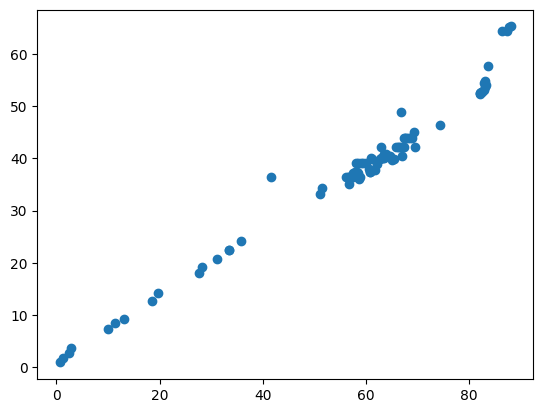

In [13]:
plt.scatter(distance_df['dist haversine'],distance_df['sp traversal'])
plt.show()

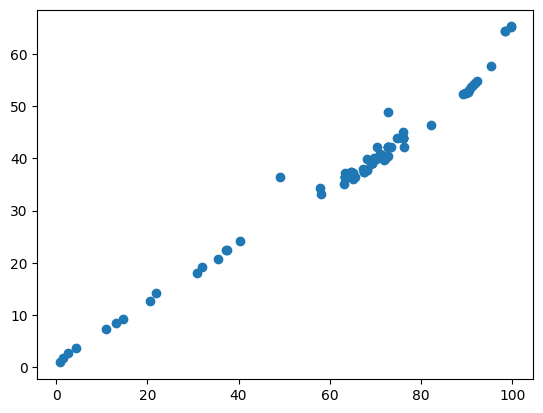

In [14]:
plt.scatter(distance_df['sp length']/1000,distance_df['sp traversal'])
plt.show()

In [ ]:
# Bring in road and direction
# Select two roads leading into Dover separately
# For a single month - get aggregated data at hourly level for weekend vs weekday

In [15]:
compare_sensors = pd.DataFrame(index = ts_all_2.index)

compare_sensors['ts1'] = ts_all_1['All Lanes_interpolated']
compare_sensors['ts2'] = ts_all_2['All Lanes_interpolated']

# Compute cross-correlation
cross_corr_matrix = compare_sensors.corr()
print(cross_corr_matrix)

          ts1       ts2
ts1  1.000000  0.207691
ts2  0.207691  1.000000


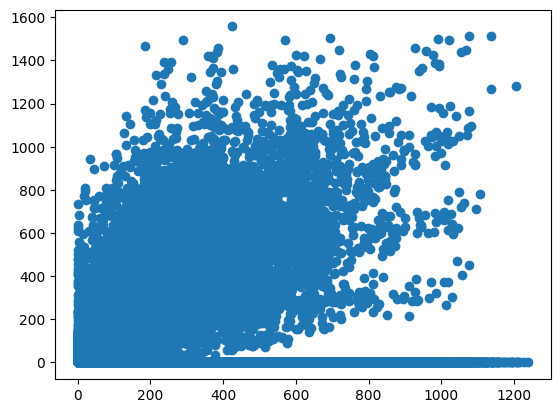

In [16]:
#Scatter Plots

plt.scatter(compare_sensors['ts1'],compare_sensors['ts2'])
plt.show()

In [ ]:
#Road Analysis

#For a road coming out of Dover
#Line up sensors in order
#Each sensor determine which other sensors are reachable in 15 minutes
#Compute 30 minutes isochrones
#Compute all sensor pairs correlatin
#Road level flow evolution analysis

In [57]:
#Read in sensors for A20 route

with open('Data/route1_a20.csv', newline='') as f:
    a20_sensors = f.read().splitlines()
print(a20_sensors)

['5892/1', '5889/1', 'A20/7113A', 'M20/7095A', 'M20/7076A', 'M20/7018A', 'M20/6913A', 'M20/6905A', 'M20/6868A', 'M20/6645A', 'M20/6590A', 'M20/6582A', 'M20/6576A', 'M20/6572A', 'M20/6570A', 'M20/6568A1', 'M20/6552A1', 'M20/6545A', 'M20/6547A1', 'M20/6540A', 'M20/6534A', 'M20/6538A', 'M20/6531A', 'M20/6526A', 'M20/6518A', 'M20/6520A', 'M20/6523A', 'M20/6514A', 'M20/6517A', 'M20/6506A', 'M20/6511A', 'M20/6501A', 'M20/6498A', 'M20/6481A', 'M20/6484A', 'M20/6487A', 'M20/6491A', 'M20/6494A', 'M20/6477A', 'M20/6460A', 'M20/6465A', 'M20/6468A', 'M20/6472A', 'M20/6476A', 'M20/6454A', 'M20/6404A']


In [58]:
start_date = '2022-01-01'
end_date = '2022-12-31 23:45:00'

# Create a datetime index with 15-minute frequency
datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')

/tmp/ipykernel_321868/1344023103.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


In [59]:
a20_ts_data_raw = pd.DataFrame(index = datetime_index, columns = a20_sensors)
a20_ts_data_int = pd.DataFrame(index = datetime_index, columns = a20_sensors)

for site in a20_sensors:
    ts, ts_all = get_ts(site,start_date,end_date,cursor)
    a20_ts_data_raw[site] = ts_all['All Lanes']
    a20_ts_data_int[site] = ts_all['All Lanes_interpolated']

/tmp/ipykernel_321868/1484312045.py:108: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
/tmp/ipykernel_321868/1484312045.py:126: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/tmp/ipykernel_321868/1484312045.py:126: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior w

In [ ]:
# Each sensor in turn
# SPQ to all other sensors in road
# Count number of sensors reachable in 15min, 30 mins, 45 mins and 1 hour
# Get flow correlation for each month and year

In [20]:
from_sensor = a20_sensors[0]
from_sensor_node = sensors_in_study[sensors_in_study['site_ID'] == from_sensor]['nearest node'].values[0]

to_sensor = a20_sensors[1]
to_sensor_node = sensors_in_study[sensors_in_study['site_ID'] == to_sensor]['nearest node'].values[0]

travel_time = nx.dijkstra_path_length(G, from_sensor_node, to_sensor_node, weight='traversal_cost')
print(travel_time)

3.696213975915593


In [21]:
ts_from, ts_all_from = get_ts(from_sensor,start_date,end_date,cursor)
ts_to, ts_all_to = get_ts(to_sensor,start_date,end_date,cursor)

compare_sensors = pd.DataFrame(index = ts_all_2.index)

compare_sensors['ts1'] = ts_all_from['All Lanes_interpolated']
compare_sensors['ts2'] = ts_all_to['All Lanes_interpolated']

# Compute cross-correlation
cross_corr_matrix = compare_sensors.corr()
print(cross_corr_matrix)

/tmp/ipykernel_321868/1484312045.py:108: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
/tmp/ipykernel_321868/1484312045.py:126: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/tmp/ipykernel_321868/1484312045.py:126: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior w

     ts1  ts2
ts1  NaN  NaN
ts2  NaN  1.0


/tmp/ipykernel_321868/1484312045.py:108: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
/tmp/ipykernel_321868/1484312045.py:126: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/tmp/ipykernel_321868/1484312045.py:126: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior w

In [74]:
dover = Point(1.313484253539137,51.123268155847605)
dover_node = ox.distance.nearest_nodes(G, dover.x, dover.y, return_dist=False)
sensor_level_data_list = []
route = 'route1'
# Sensor to Sensor Matrix
s2s_time = np.zeros((len(a20_sensors),len(a20_sensors)))
s2s_corr = np.zeros((len(a20_sensors),len(a20_sensors)))
u_i = 0
sensor_num = 1

for u in a20_sensors:
    
    sensor_level_append = {}
    sensor_level_append['sensor'] = u
    u_node = sensors_in_study[sensors_in_study['site_ID'] == u]['nearest node'].values[0]
    v_i = 0
    count_15 = 0
    count_30 = 0
    count_45 = 0
    count_60 = 0
    for v in a20_sensors:
        v_node = sensors_in_study[sensors_in_study['site_ID'] == v]['nearest node'].values[0]
        #SP
        travel_time = nx.dijkstra_path_length(G, u_node, v_node, weight='traversal_cost')
        #Correlation
        correlation = np.corrcoef(a20_ts_data_int[u].values,a20_ts_data_int[v].values)
        #Append to matrix
        s2s_time[u_i,v_i] = travel_time
        s2s_corr[u_i,v_i] = correlation[0][1]
        
        if travel_time <= 15:
            count_15 += 1
        if travel_time <= 30:
            count_30 += 1
        if travel_time <= 45:
            count_45 += 1
        if travel_time <= 60:
            count_60 += 1
        v_i += 1
    
    sensor_level_append['Reachable 15'] = count_15
    sensor_level_append['Reachable 30'] = count_30
    sensor_level_append['Reachable 45'] = count_45
    sensor_level_append['Reachable 60'] = count_60
    
    #Dist to dover
    dist_to_dover = nx.dijkstra_path_length(G, u_node, dover_node, weight='traversal_cost')
    sensor_level_append['Time to Dover'] = dist_to_dover
    
    sensor_level_data_list.append(sensor_level_append)
    
    #Isocrone    
    
    #Get 15 min isochrone from sensor

    start_node = u_node
    max_travel_time = 15

    queue = [(0, start_node)]

    # Dictionary to store the cumulative travel time for each node
    travel_times = {node: float('inf') for node in G.nodes}
    travel_times[start_node] = 0

    while queue:
        current_time, current_node = heapq.heappop(queue)
        
        # Check if the current node has been reached within the allowed travel time
        if current_time > max_travel_time:
            print('Time over allowed traversal time')
            break
        
        for neighbor in G.neighbors(current_node):
            # Calculate the total travel time to the neighbor from the start node
            neighbor_time = current_time + G[current_node][neighbor][0]['traversal_cost']
            
            # Update the travel time if it's smaller than the current recorded time
            if neighbor_time < travel_times[neighbor]:
                travel_times[neighbor] = neighbor_time
                heapq.heappush(queue, (neighbor_time, neighbor))
                
    isocrone = node_attributes.loc[[node for node, time in travel_times.items() if time <= max_travel_time]]
    isocrone['travel time'] = isocrone.index.map(travel_times)

    isocrone_gdf = GeoDataFrame(isocrone, crs="EPSG:4326", geometry=isocrone['geometry'])
    isocrone_gdf.to_file("Data/route1/isochrone_{}_{}.json".format(route,sensor_num), driver="GeoJSON")
    
    sensor_num += 1
    u_i += 1
    
sensor_level_data = pd.DataFrame(sensor_level_data_list)

/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


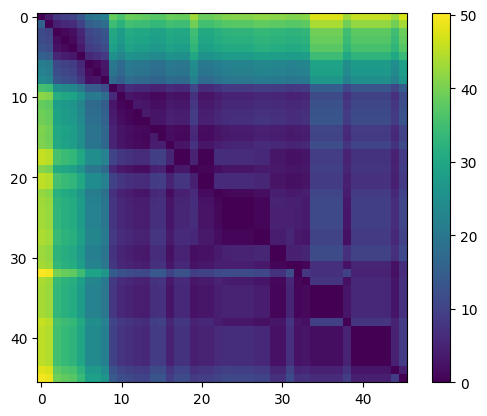

In [64]:
# Create a mask for NaN values
nan_mask = np.isnan(s2s_time)

# Create a heatmap with nan values greyed out
plt.imshow(np.ma.masked_where(nan_mask, s2s_time), cmap='viridis', interpolation='none')

# Add colorbar
plt.colorbar()

# Show the plot
plt.show()

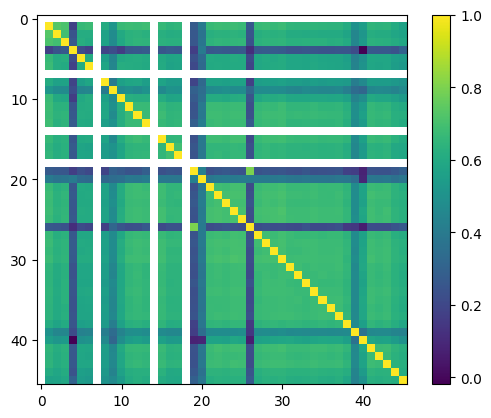

In [63]:
# Create a mask for NaN values
nan_mask = np.isnan(s2s_corr)

# Create a heatmap with nan values greyed out
plt.imshow(np.ma.masked_where(nan_mask, s2s_corr), cmap='viridis', interpolation='none')

# Add colorbar
plt.colorbar()

# Show the plot
plt.show()

In [87]:
jan_weekday_data = a20_ts_data_int[(a20_ts_data_int.index.month == 1)&(a20_ts_data_int.index.weekday < 5)]
jan_weekend_data = a20_ts_data_int[(a20_ts_data_int.index.month == 1)&(a20_ts_data_int.index.weekday >= 5)]

In [88]:
hourly_mean_weekday = jan_weekday_data.groupby(jan_weekday_data.index.hour).mean()
hourly_mean_weekend = jan_weekend_data.groupby(jan_weekend_data.index.hour).mean()

In [94]:
hourly_mean_weekday

,5892/1,5889/1,A20/7113A,M20/7095A,M20/7076A,M20/7018A,M20/6913A,M20/6905A,M20/6868A,M20/6645A,...,M20/6491A,M20/6494A,M20/6477A,M20/6460A,M20/6465A,M20/6468A,M20/6472A,M20/6476A,M20/6454A,M20/6404A
0,0.0,17.704762,13.946429,16.166667,1.035714,20.827381,16.178571,0.0,4.809524,26.767857,...,48.505952,47.750000,53.005952,35.753968,0.0,53.595238,47.815476,54.619048,31.553571,27.815476
1,0.0,17.745635,13.880952,17.595238,0.523810,19.065476,14.712302,0.0,3.154762,22.446429,...,49.696429,39.375000,46.119048,34.871032,0.0,43.500000,45.880952,42.380952,27.011905,24.494048
2,0.0,16.908673,11.687500,14.577381,0.769841,19.363095,17.115079,0.0,3.613095,25.065476,...,45.136905,41.333333,42.714286,34.559524,0.0,40.214286,45.172619,42.892857,27.291667,21.690476
3,0.0,23.522449,18.651786,21.607143,1.152778,21.767857,17.910714,0.0,4.779762,31.654762,...,51.636905,45.482143,45.285714,40.898810,0.0,51.648810,48.422619,50.666667,28.791667,22.083333
4,0.0,28.296854,26.416667,26.589286,1.491071,32.142857,24.601190,0.0,6.648810,37.434524,...,67.250000,62.779762,61.916667,47.696429,0.0,66.154762,64.011905,57.928571,36.839286,30.511905
5,0.0,41.014286,33.130952,34.892857,3.279762,44.509921,37.071429,0.0,12.119048,68.279762,...,96.863095,88.095238,81.767857,68.636905,0.0,103.130952,89.226190,102.863095,48.875000,55.005952
6,0.0,73.090079,55.500000,76.666667,12.532738,91.478175,71.773810,0.0,53.994048,164.934524,...,192.755952,198.023810,213.327381,184.529762,0.0,245.315476,206.892857,231.464286,127.964286,128.642857
7,0.0,144.996230,117.902778,144.803571,43.630952,181.327381,146.833333,0.0,146.553571,267.095238,...,386.565476,367.880952,439.113095,338.130952,0.0,389.071429,403.154762,411.654762,228.295635,217.250000
8,0.0,180.840079,132.168651,154.863095,59.113095,191.053571,146.476190,0.0,96.964286,214.928571,...,314.190476,321.047619,395.428571,288.976190,0.0,370.226190,312.369048,393.309524,173.638889,174.625000
9,0.0,128.151984,95.684524,133.642857,36.130952,135.321429,120.577381,0.0,70.916667,189.375000,...,293.690476,283.910714,332.714286,256.279762,0.0,352.333333,306.005952,311.839286,136.970238,135.017857


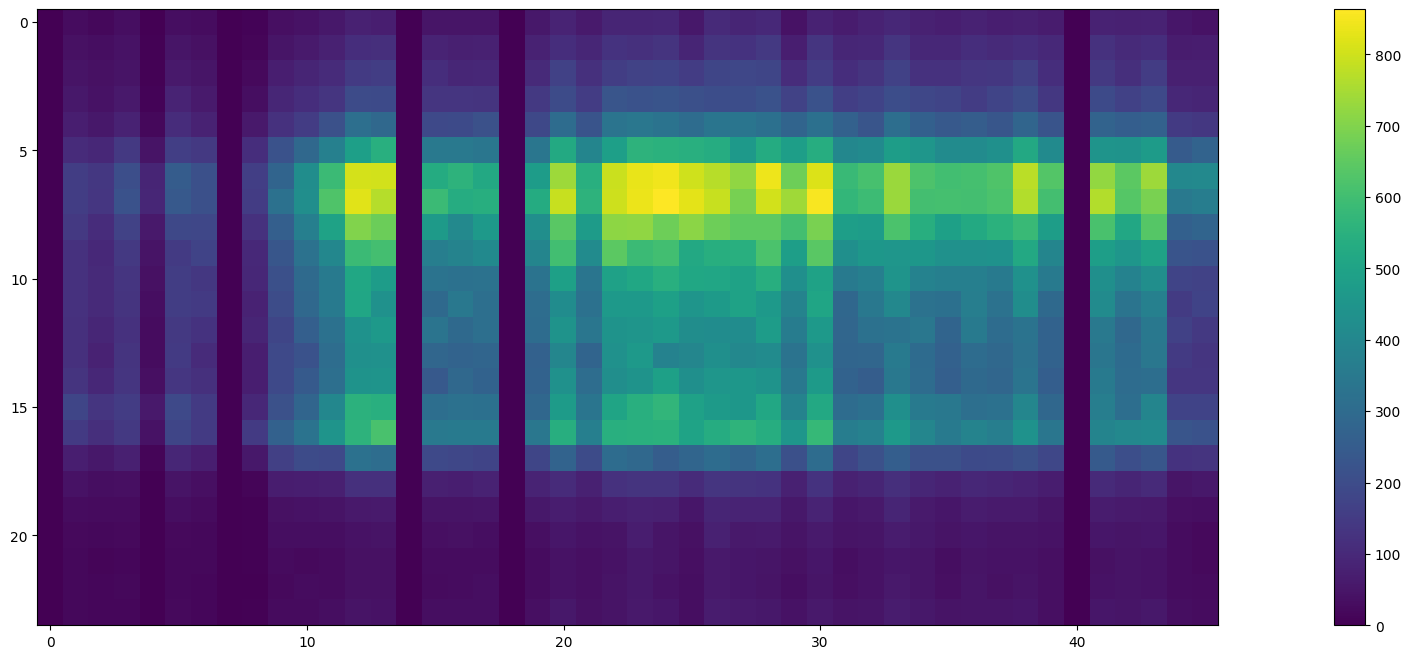

In [93]:
# Specify the size of the plot using figsize
fig, ax = plt.subplots(figsize=(30, 8))

# Plot the heatmap
im = ax.imshow(np.flip(hourly_mean_weekday.values, axis = 0), cmap='viridis', interpolation='nearest')
plt.colorbar(im, ax=ax)  # Add a colorbar on the side
# ax.set_title('Hourly Flow Heat Map')
# ax.set_xticks(np.arange(len(xlabels)))
# ax.set_xticklabels(xlabels.strftime('%B'))
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1,bymonthday=15))

# ax.set_yticks(np.arange(len(ylabels)))
# ax.set_yticklabels(ylabels)
# ax.yaxis.set_major_locator(MultipleLocator(4))

plt.show()

In [ ]:
#Analysis - data quality evaluation over road
#sensors on x
#months on y
#sideways bar chart to show missingness, 0s and outliers

In [ ]:
zero_counts[0,array_ind] = ((day_data['Lane 1'] == 0).sum() / len(day_data)) * 100
zero_counts[1,array_ind] = ((day_data['Lane 2'] == 0).sum() / len(day_data)) * 100
zero_counts[2,array_ind] = ((day_data['Lane 3'] == 0).sum() / len(day_data)) * 100
zero_counts[3,array_ind] = ((day_data['All Lanes'] == 0).sum() / len(day_data)) * 100

null_counts[0,array_ind] = (day_data['Lane 1'].isnull().sum() / len(day_data)) * 100
null_counts[1,array_ind] = (day_data['Lane 2'].isnull().sum() / len(day_data)) * 100
null_counts[2,array_ind] = (day_data['Lane 3'].isnull().sum() / len(day_data)) * 100
null_counts[3,array_ind] = (day_data['All Lanes'].isnull().sum() / len(day_data)) * 100

outlier_counts[0,array_ind] = (((day_data['Lane 1'] > mean_value_l1 + 2 * std_dev_l1) | (day_data['Lane 1'] < mean_value_l1 - 2 * std_dev_l1)).sum()) / len(day_data) * 100
outlier_counts[1,array_ind] = (((day_data['Lane 2'] > mean_value_l2 + 2 * std_dev_l2) | (day_data['Lane 1'] < mean_value_l2 - 2 * std_dev_l2)).sum()) / len(day_data) * 100
outlier_counts[2,array_ind] = (((day_data['Lane 3'] > mean_value_l3 + 2 * std_dev_l3) | (day_data['Lane 1'] < mean_value_l3 - 2 * std_dev_l3)).sum()) / len(day_data) * 100
outlier_counts[3,array_ind] = (((day_data['All Lanes'] > mean_value_lall + 2 * std_dev_lall) | (day_data['All Lanes'] < mean_value_lall - 2 * std_dev_lall)).sum()) / len(day_data) * 100

In [116]:
zeros = np.zeros((a20_ts_data_raw.shape[1],12))
nulls = np.zeros((a20_ts_data_raw.shape[1],12))
outliers = np.zeros((a20_ts_data_raw.shape[1],12))

for m in range(12):
    month_data = a20_ts_data_raw[a20_ts_data_raw.index.month == 1]

    mean_value = month_data.mean()
    std_dev = month_data.std()

    zeros[:,m-1] = ((month_data == 0).sum() / len(month_data)) * 100
    nulls[:,m-1] = (month_data.isnull().sum() / len(month_data)) * 100
    outliers[:,m-1] = (((month_data > mean_value + 2 * std_dev) | (month_data < mean_value - 2 * std_dev)).sum()) / len(month_data) * 100

In [120]:
month_data

,5892/1,5889/1,A20/7113A,M20/7095A,M20/7076A,M20/7018A,M20/6913A,M20/6905A,M20/6868A,M20/6645A,...,M20/6491A,M20/6494A,M20/6477A,M20/6460A,M20/6465A,M20/6468A,M20/6472A,M20/6476A,M20/6454A,M20/6404A
2022-01-01 00:00:00,NaN,5.0,3.0,15.0,1.0,17.0,17.0,0.0,NaN,27.0,...,34.0,12.0,11.0,33.0,0.0,42.0,34.0,50.0,18.0,19.0
2022-01-01 00:15:00,NaN,13.0,16.0,21.0,NaN,7.0,0.0,0.0,6.0,0.0,...,31.0,30.0,22.0,5.0,0.0,35.0,7.0,21.0,11.0,0.0
2022-01-01 00:30:00,NaN,NaN,NaN,30.0,5.0,34.0,23.0,0.0,0.0,27.0,...,73.0,69.0,55.0,46.0,0.0,68.0,69.0,76.0,NaN,45.0
2022-01-01 00:45:00,NaN,15.0,11.0,25.0,1.0,NaN,19.0,0.0,0.0,46.0,...,57.0,2.0,4.0,45.0,0.0,96.0,67.0,4.0,18.0,2.0
2022-01-01 01:00:00,NaN,13.0,3.0,18.0,0.0,39.0,6.0,0.0,5.0,NaN,...,54.0,83.0,NaN,21.0,NaN,83.0,14.0,54.0,20.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 22:45:00,NaN,29.0,31.0,46.0,0.0,46.0,33.0,NaN,8.0,38.0,...,102.0,101.0,114.0,0.0,0.0,85.0,76.0,44.0,73.0,43.0
2022-01-31 23:00:00,NaN,37.0,NaN,61.0,0.0,35.0,23.0,0.0,9.0,44.0,...,4.0,87.0,58.0,44.0,0.0,111.0,48.0,117.0,22.0,54.0
2022-01-31 23:15:00,NaN,30.0,28.0,NaN,NaN,18.0,28.0,0.0,7.0,11.0,...,98.0,3.0,70.0,66.0,0.0,69.0,53.0,98.0,70.0,60.0
2022-01-31 23:30:00,NaN,NaN,22.0,28.0,0.0,36.0,31.0,0.0,NaN,34.0,...,95.0,35.0,55.0,1.0,0.0,113.0,39.0,81.0,44.0,15.0
